In [1]:
# This is the notebook for honours project analysis on galaxy cluster XLSSC 122
# This notebook will serve as sort of a journal of what is done on the project
# Proceeds chronologically with updated TODOs:

# Notebook part 4: correlation on true data
# First we load in the necessary modules:

# Standard libraries
import numpy as np;import scipy as sp;import matplotlib.pyplot as plt
import math;import warnings;import cv2
import matplotlib.ticker as tck

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.patches import Ellipse, Circle


# astro specific
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
#plt.style.use(astropy_mpl_style)
plt.style.use('default')
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import convolve, convolve_fft

import FITS_tools
from operator import itemgetter

#plt.style.use('seaborn-deep')

# 3d plotting for mostly fun:
from mpl_toolkits import mplot3d
from skimage import io, transform 

# image reprojection:
from reproject import reproject_interp
import reproject
from matplotlib import rc

from matplotlib import rc

params = {"text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["cmr10"],
          "font.size": 20
         }
plt.rcParams.update(params)
plt.rcParams['axes.formatter.use_mathtext'] = True

import os
os.environ["PATH"]
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin/'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

# Set tick parameters using rcParams
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.major.width'] = 0.7
plt.rcParams['xtick.minor.width'] = 0.7
plt.rcParams['ytick.major.width'] = 0.7
plt.rcParams['ytick.minor.width'] = 0.7

plt.rcParams['font.weight'] = 'bold'

from matplotlib.colors import PowerNorm



In [2]:
# DATA:

# Now need to load in the data files for the fits image as well as the catalogues:

# fits:

fits_path ="/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/IVM_xlssuj0217-0345-f140w_drz_sci.fits"
xlssc_fits = fits.open(fits_path)

# extracted fits:

extract_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/xlssuj0217-0345-f140w_drz_seg_spec_extract.fits"
extract_fits = fits.open(extract_path)

# x-ray image:

xray_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/image400-3000_comb.fits"
xray_fits = fits.open(xray_path)

# smoothed x-ray image:

smooth_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/asmooth.fits"
smooth_fits = fits.open(smooth_path)

# catalogue files:

# shape of short file: 12 X 1374
# id ra dec (F105) kron ekron 0p8 e0p8 (F140) kron ekron 0p8 e0p8 fwhm (asec) 

cat_sh_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/xlssc122_F105_F140_short.cat"
cat_sh = np.loadtxt(cat_sh_path)

# shape of long file: 22 X 1301
# phot-id ra dec (f105) kron ekron 0p8 e0p8 (f140) kron ekron 0p8 e0p8 fwhm (asec) zz zlo zhi chi spec-id mcode snr em-code member1 member2

cat_lo_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/xlssc122_F105_F140_redshifts_short_v4_snr_em_member2_by_hand.cat"
cat_lo = np.loadtxt(cat_lo_path)

# data tble for members is the following shape 11 x 50:
#ID	RA (Deg)	DEC (Deg)	Mag (140W)	Colour	Z	Membership	quality	Age (Gyr)	Tau	Mass (log10(M/Ms))

data_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/extended_data_table.csv"
member_data = np.loadtxt(data_path, dtype='str',delimiter=',', skiprows=1).T

# syntax to sort a list of lists :
#sorted_by_140W = sorted(member_data.T, key=itemgetter(3))

# individual arrays of data for member galaxies:
nat_ID = np.array(member_data[0], dtype=float);  nat_RA = np.array(member_data[1], dtype=float);
nat_DEC = np.array(member_data[2], dtype=float); nat_mag = np.array(member_data[3], dtype=float);
nat_col = np.array(member_data[4], dtype=float); nat_z = np.array(member_data[5], dtype=float);
nat_notes = np.array(member_data[6], dtype=str); nat_quality = np.array(member_data[7], dtype=str)
nat_age =  np.array(member_data[8], dtype=float);nat_tau = np.array(member_data[9], dtype=float)
nat_mass =  np.array(member_data[10], dtype=float)

In [3]:
# projections:
xlssc_hdu = fits.open(fits_path)[0]
xlssc_wcs = WCS(xlssc_hdu.header)    
extract_hdu = fits.open(extract_path)[0]
extract_wcs = WCS(extract_hdu.header)
xray_hdu = fits.open(xray_path)[0]
xray_wcs = WCS(xray_hdu.header)
xray_smooth_hdu = fits.open(smooth_path)[0]
xray_smooth_wcs = WCS(xray_smooth_hdu.header)
xlssc_image = fits.getdata(fits_path, ext=0)
extract_image = fits.getdata(extract_path, ext=0)
xray_image = fits.getdata(xray_path, ext=0)
xray_smooth_image = fits.getdata(smooth_path, ext=0)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 57219.298958 from DATE-OBS.
Set MJD-END to 57220.498646 from DATE-END'. [astropy.wcs.wcs]


In [4]:
# first step of this notebook is to filter all of the data so that we are using the 
# correct things for each part. We have 37 total confirmed members: 15 gold, 11 Silver, 11, Bronze

# the data csv has been update to include only the 37 members with the CATALOG magnitudes and positions.
# the fluxes have also been included for all 7 methods

# way to sort a list using dictionary key-values
# nat_ID_dict = {x: i for i, x in enumerate(nat_ID[0:37])}
# member_data = [0 for i in range(len(mem_data))]
# for i in range(len(member_data)):
#     index = np.array(mem_data).T[5][i]
#     up_ind  = nat_ID_dict[index]
#     member_data[up_ind] = mem_data[i]

# update member data matrix found in member_data_extended: of the form
# ID	RA (Deg)	DEC (Deg)	Mag (105W)	Mag (140W)	Mag (140W).2	Colour.2	Colour	Z	Membership	quality	Age (Gyr)	Tau	
# Mass (log10(M/Ms))	Fluxes: int0	int1	int2	int3	Hanning	Gaussian	Exact	 manual

data_path = '/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/member_data_extended.csv'
mem_data = np.loadtxt(data_path, skiprows=1, delimiter=',', dtype='float', encoding='latin-1').T


In [5]:
# we need to acquire a manual set of flux values. We will do this in DS9 but it will be useful
# to generate a region file for all members:

# for i in range(len(mem_data[0])):
#     DEC = float(mem_data[1][i]);RA=float(mem_data[2][i])
#     mem = mem_data[10][i]; ID = int(mem_data[0][i])
#     print(mem)
#     if mem=='gold':
#         print(f'circle({DEC:0.6f},{RA:0.6f}, 0.001) # color=red text=\"{ID}\"')
#     elif mem=='silver':
#         print(f'circle({DEC:0.6f},{RA:0.6f}, 0.001) # color=blue text=\"{ID}\"')
#     elif mem=='bronze':
#         print(f'circle({DEC:0.6f},{RA:0.6f}, 0.001) # color=magenta text=\"{ID}\"')

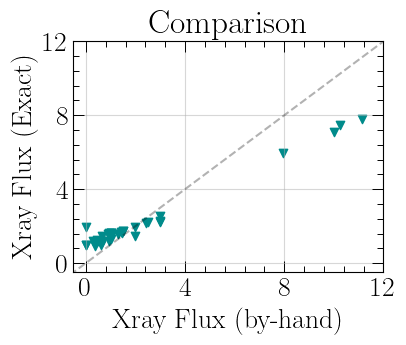

In [6]:
# now we want to compare the manual values to the other methods:

width=4;height=3;ff, ax1 = plt.subplots(1,1, sharex=True, sharey=True);ff.set_figwidth(width);ff.set_figheight(height)

ax1.set_xlim(-0.5,12)
ax1.set_ylim(-0.5,12)
ax1.set_title("Comparison")
ax1.set_ylabel(r"Xray Flux (Exact)")
ax1.set_xlabel(r"Xray Flux (by-hand)")

ax1.scatter(mem_data[21], mem_data[20], marker='v', c='darkcyan')

xplot = np.linspace(-1,12,100)

ax1.plot(xplot,xplot, c='k', linestyle='--', alpha=0.3)

ax1.xaxis.set_major_locator(MultipleLocator(4))
ax1.xaxis.set_minor_locator(MultipleLocator(0.8))
ax1.yaxis.set_minor_locator(MultipleLocator(0.8))
ax1.yaxis.set_major_locator(MultipleLocator(4))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid(True, alpha=0.5, zorder=10)
plt.show()

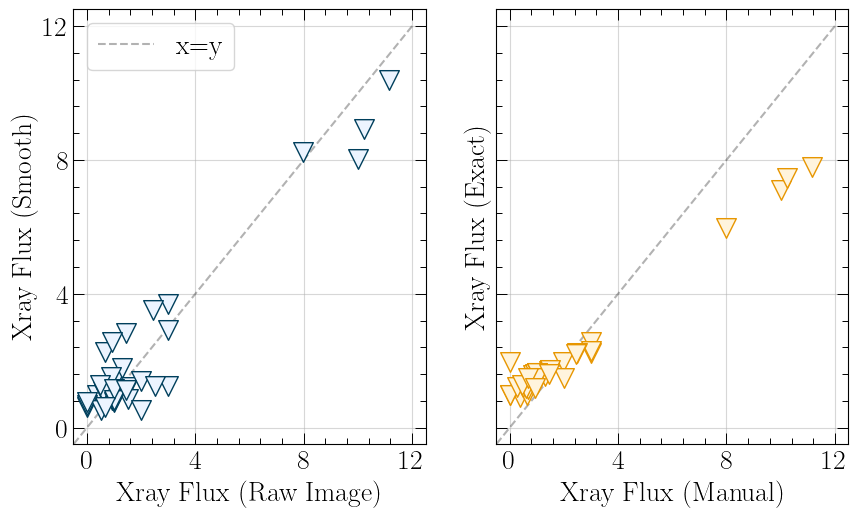

In [7]:
# Also of interest is comparing the manual smooth and manula raw xray fluxes:

width=10;height=5.65;ff, (ax1,ax2) = plt.subplots(1,2, sharex=True, sharey=True);ff.set_figwidth(width);ff.set_figheight(height)
#ff.tight_layout(pad=5)
ax1.set_xlim(-0.5,12.5)
ax1.set_ylim(-0.5,12.5)
ax1.set_ylabel(r"Xray Flux (Smooth)")
ax1.set_xlabel(r"Xray Flux (Raw Image)")

ax1.scatter(mem_data[21], mem_data[22], marker='v', edgecolor='#003f5c',c='#ecf4ff',s=200,zorder=200)
ax1.plot(xplot,xplot, c='k', linestyle='--', alpha=0.3,label=r'x=y')

ax1.xaxis.set_major_locator(MultipleLocator(4))
ax1.xaxis.set_minor_locator(MultipleLocator(0.8))
ax1.yaxis.set_minor_locator(MultipleLocator(0.8))
ax1.yaxis.set_major_locator(MultipleLocator(4))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid(True, alpha=0.5, zorder=10)

ax2.set_xlim(-0.5,12.5)
ax2.set_ylim(-0.5,12.5)
ax2.set_ylabel(r"Xray Flux (Exact)")
ax2.set_xlabel(r"Xray Flux (Manual)")

ax2.scatter(mem_data[21], mem_data[20], marker='v', edgecolor='#e79600',c='#fff4dd', s=200,zorder=5)

xp2ot = np.linspace(-1,12,100)

ax2.plot(xplot,xplot, c='k', linestyle='--', alpha=0.3, label=r'x=y')

ax2.xaxis.set_major_locator(MultipleLocator(4))
ax2.xaxis.set_minor_locator(MultipleLocator(0.8))
ax2.yaxis.set_minor_locator(MultipleLocator(0.8))
ax2.yaxis.set_major_locator(MultipleLocator(4))
ax2.tick_params(axis='both', direction="in")
ax2.tick_params(which="minor", axis="x", direction="in")
ax2.tick_params(which="minor", axis="y", direction="in")
ax2.xaxis.set_ticks_position('both') 
ax2.yaxis.set_ticks_position('both')
ax2.grid(True, alpha=0.5, zorder=10)

ax1.legend()
plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/3_flux_methods_comparison", dpi=250)


In [8]:
mem_ID = np.array(member_data[0], dtype=float); mem_RA = np.array(member_data[1], dtype=float);
mem_DEC = np.array(member_data[2], dtype=float); mem_mag = np.array(member_data[3], dtype=float);
mem_col = np.array(member_data[4], dtype=float); mem_z = np.array(member_data[5], dtype=float);

mem_notes = np.array(member_data[6], dtype=str)
# creates masks for each member group:

gold_mask = np.array([0.0 for i in range(len(mem_ID))])
silver_mask = np.array([0.0 for i in range(len(mem_ID))])
fg_mask = np.array([0.0 for i in range(len(mem_ID))])
e_mask = np.array([0.0 for i in range(len(mem_ID))])

for i in range(len(mem_notes)):
    note = mem_notes[i]
    
    if (note == 'G' or note =='GE'):
        gold_mask[i] = 1
        silver_mask[i] = float("nan")
        fg_mask[i] = float("nan")
        if note == 'GE':
            e_mask[i] = 1
    elif (note == 'SE' or note == 'S'):
        gold_mask[i] = float("nan")
        silver_mask[i] = 1
        fg_mask[i] = float("nan")
        if note == 'SE':
            e_mask[i] = 1
    elif (note == 'F'):
        gold_mask[i] = float("nan")
        silver_mask[i] = float("nan")
        fg_mask[i] = 1

In [9]:
for i in range(len(member_data[-1])):
    try float(

SyntaxError: expected ':' (1045077207.py, line 2)

In [10]:
gold_mass = [float(member_data[-1][i]) for i in range(len(member_data[-1])-13)]*gold_mask

ValueError: operands could not be broadcast together with shapes (37,) (50,) 

In [11]:
gold_mass

NameError: name 'gold_mass' is not defined

In [12]:
mem_data[7]

array([1.44, 1.29, 1.49, 1.33, 1.56, 0.43, 1.42, 1.37, 1.35, 1.28, 1.2 ,
       1.38, 0.66, 1.43, 1.31, 1.27, 0.48, 1.38, 0.46, 0.47, 0.66, 1.61,
       1.54, 1.28, 0.45, 1.02,  nan, 0.28, 1.38, 0.49, 0.46, 0.3 , 0.5 ,
       1.3 , 0.39, 0.62, 0.81])

NameError: name 'red_m26' is not defined

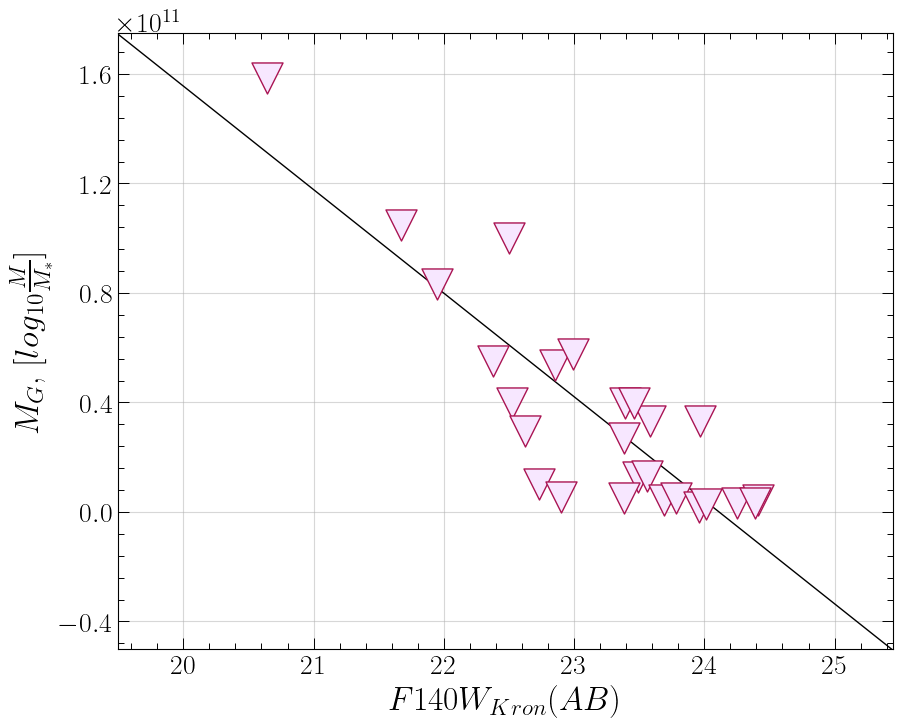

In [13]:
# we will now do the same as last time and investigate the masses of the galaxies:

# first need to convert nans into zeroes so it is plottable:
mem_mass = mem_data[13]; mem_mag = mem_data[4]

mem_mass[np.isnan(mem_mass)] = 0; nonzero_mass = [i for i in mem_mass if i != 0]
nonzero_mag = [mem_mag[i] for i in range(len(mem_mass)) if mem_mass[i] != 0 ]
zero_mag = [mem_mag[i] for i in range(len(mem_mass)) if mem_mass[i] == 0 ]

# and in stellar units:
unlog_mass = [10**mem_mass[i] for i in range(len(mem_mass))]

# we can now plot mass against magnitude:

width=10;height=8;ff, ax1 = plt.subplots(1,1, sharex=True, sharey=True);ff.set_figwidth(width);ff.set_figheight(height)

#ax1.set_xlim(20,25)
#ax1.set_ylim(8,12)
#ax1.set_title("Galaxy Stellar Mass as a Function of Magnitude")
ax1.set_ylabel(r"$M_{G}$, $[log_{10}\frac{M}{M_{\ast}}]$", fontsize=24)
ax1.set_xlabel(r"$F140W_{Kron}(AB)$",fontsize=24)

ax1.scatter(nonzero_mag, 10**np.array(nonzero_mass), marker='v', c='#f7e7ff', s=500, edgecolor='#aa1553', zorder=10)
#c37aae
ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.xaxis.set_minor_locator(MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(MultipleLocator(0.08e11))
ax1.yaxis.set_major_locator(MultipleLocator(0.4e11))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid(True, alpha=0.5, zorder=10)


m_mass,b_mass = np.polyfit(nonzero_mag,10**np.array(nonzero_mass),1)
xx = np.linspace(18,26,100)

ax1.plot(xx,m_mass*xx+b_mass,color='k',linestyle='-',linewidth=1)
#ax1.scatter(zero_mag, m_mass*np.array(zero_mag)+b_mass,s=600, marker='|',zorder=10,alpha=0.5,c='navy')

ax1.set_ylim(-0.5e11, 1.75e11)
ax1.set_xlim(19.5,25.45)

plt.scatter(red_m26[4],10**red_m26[23], zorder=100)
plt.scatter(blue_m26[4],10**blue_m26[23], zorder=100, )


plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/3_mass_interpolation", dpi=250)


In [14]:
red_m26[3]

NameError: name 'red_m26' is not defined

In [15]:
# now want to create a sample where all of the missing masses are removed as 
# well as a sample with added masses due to the linear relation established above:

# next sample with extrapolated masses:
mem_data_m37 = mem_data.T; masses = 10**mem_data[13]; mags = mem_data[4]

for i in range(len(masses)):
    if np.isnan(masses[i]) == True:
        mass = (m_mass*mags[i] +b_mass)
        if mass< 0:
            mass = 10**min(mem_data_m26[13])
        masses[i] = mass
              
mem_data_m37 = mem_data_m37.T; mem_data_m37[13] = np.log10(masses)

In [16]:
mem_data = np.loadtxt(data_path, skiprows=1, delimiter=',', dtype='float', encoding='latin-1').T
mem_data_m26 = mem_data.T
mem_data_m26 = np.array([mem_data_m26[i] for i in range(len(mem_data_m26)) if ((np.isnan(mem_data_m26[i][13])==False))]).T

In [17]:
# the next step is to create a third population sample that includes faint but red objects:
# to perform this analysis we will do the following:
# 1) determine the relative ratios of each type of object that has a colour above a threshold
# 2) find objects that fulfill the criteria of colour threshold, magnitude faintness and apply
#    some decision to the new members about addition to the sample motivated by the ratios from above

# first we just consider objects of colour > 1.15 from the whole catalog sample:

# using the 0.8 arcsecond circular aperture to get colour greater than 1.15:

RESTRICT = 5
mem_data_colour = np.array([cat_lo[i] for i in range(len(cat_lo)) if RESTRICT>(cat_lo[i][5]-cat_lo[i][9])>1.15]).T
pot_members = np.array([mem_data_colour.T[i] for i in range(len(mem_data_colour.T)) if mem_data_colour.T[i][7] > 24]).T
                           

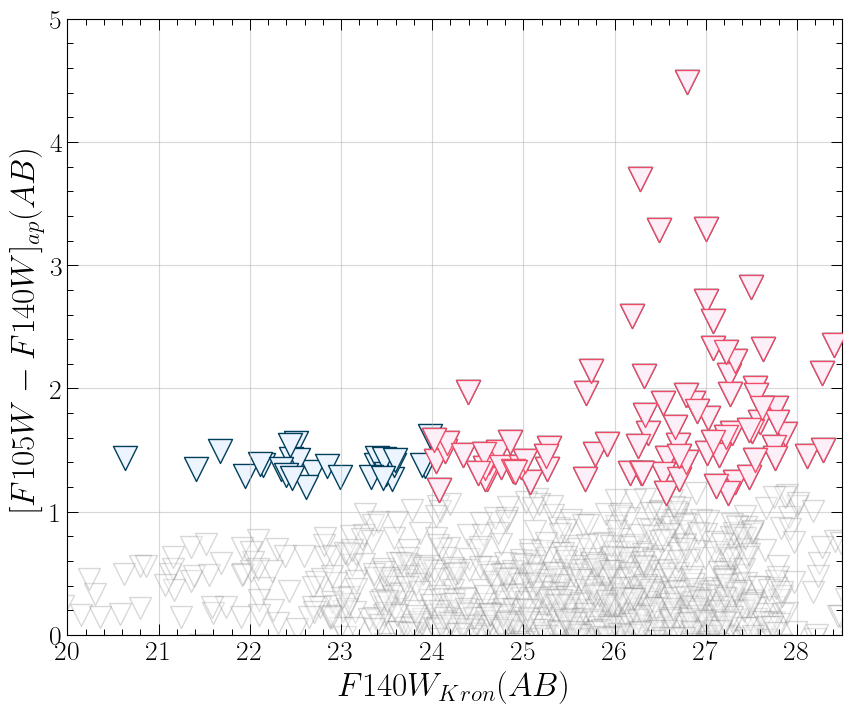

In [18]:
width=10;height=8;ff, ax1 = plt.subplots(1,1, sharex=True, sharey=True);ff.set_figwidth(width);ff.set_figheight(height)

ax1.set_xlim(20,28.5)
ax1.set_ylim(0,5)
#ax1.set_title("Galaxy Stellar Mass as a Function of Magnitude")
#ax1.set_ylabel(r"$M_{\ast}$, $[log_{10}\frac{M}{M_{\ast}}]$")
#ax1.set_xlabel(r"$F140W_{Kron}(AB)$")
ax1.set_ylabel(r"$[F105W-F140W]_{ap}(AB)$",fontsize=24)
ax1.set_xlabel(r"$F140W_{Kron}(AB)$",fontsize=24)

ax1.scatter(mem_data_colour[7], mem_data_colour[5]-mem_data_colour[9], color='#ecf4ff', edgecolor='#003f5c',zorder=1,alpha=1, marker='v',s=300)
ax1.scatter(cat_lo.T[7], cat_lo.T[5]-cat_lo.T[9],color='white', edgecolor='grey', alpha=0.3, zorder=0, marker='v',s=250)
ax1.scatter(pot_members[7], pot_members[5]-pot_members[9],color='#fdeff8', edgecolor='#ef4c68', alpha=1, zorder=50, marker='v',s=300)


ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.xaxis.set_minor_locator(MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(MultipleLocator(0.2))
ax1.yaxis.set_major_locator(MultipleLocator(1))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid(True, alpha=0.5, zorder=10)

#plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/3_extending_cm_diagram", dpi=250)


In [19]:
# now we want to go about our correlation between stellar mass of the galaxy and the 
# integrated xray flux underneath it:

# 1: all (not including extrapolated masses)
# 2: all + extrapolated masses
# 3: only red galaxies (by some colour threshold, motivated by colour-magnitude diagram)
# 4: only blue galaxies (by same colour threshold)
# 5: only old galaxies
# 6: only young galaxies

# 7: with the addition of redder and fainter galaxies (random???)

# we have the two major samples here:
mem_data_m26 = np.nan_to_num(mem_data_m26); mem_data_m37=np.nan_to_num(mem_data_m37)

# sub samples are generated here:

red_m26 = np.array([mem_data_m26.T[i] for i in range(len(mem_data_m26.T)) if (mem_data_m26.T[i][3]-mem_data_m26.T[i][4]) >1.15]).T
blue_m26 = np.array([mem_data_m26.T[i] for i in range(len(mem_data_m26.T)) if (mem_data_m26.T[i][3]-mem_data_m26.T[i][4]) <=1.15]).T

red_m37 = np.array([mem_data_m37.T[i] for i in range(len(mem_data_m37.T)) if (mem_data_m37.T[i][3]-mem_data_m37.T[i][4]) >1.15]).T
blue_m37 = np.array([mem_data_m37.T[i] for i in range(len(mem_data_m37.T)) if (mem_data_m37.T[i][3]-mem_data_m37.T[i][4]) <=1.15]).T

old_m26 = np.array([mem_data_m26.T[i] for i in range(len(mem_data_m26.T)) if mem_data_m26.T[i][11]>1.0]).T
young_m26 = np.array([mem_data_m26.T[i] for i in range(len(mem_data_m26.T)) if mem_data_m26.T[i][11]<=1.0]).T

old_m37 = np.array([mem_data_m37.T[i] for i in range(len(mem_data_m37.T)) if mem_data_m37.T[i][11]>1.0]).T
young_m37 = np.array([mem_data_m37.T[i] for i in range(len(mem_data_m37.T)) if mem_data_m37.T[i][11]<=1.0]).T


# mass is found at index 13 for the member data; xray flux are found at index 14-22
m26_corr = [sp.stats.pearsonr(10**mem_data_m26[13], mem_data_m26[i+14]) for i in range(9)]

m26_corr_red = [sp.stats.pearsonr(10**red_m26[13], red_m26[i+14]) for i in range(9)]
m26_corr_blue = [sp.stats.pearsonr(10**blue_m26[13], blue_m26[i+14]) for i in range(9)]

m26_corr_old = [sp.stats.pearsonr(10**old_m26[13], old_m26[i+14]) for i in range(9)]
m26_corr_young = [sp.stats.pearsonr(10**young_m26[13], young_m26[i+14]) for i in range(9)]

m37_corr = [sp.stats.pearsonr(10**mem_data_m37[13], mem_data_m37[i+14]) for i in range(9)]

m37_corr_red = [sp.stats.pearsonr(10**red_m37[13], red_m37[i+14]) for i in range(9)]
m37_corr_blue = [sp.stats.pearsonr(10**blue_m37[13], blue_m37[i+14]) for i in range(9)]

m37_corr_old = [sp.stats.pearsonr(10**old_m37[13], old_m37[i+14]) for i in range(9)]
m37_corr_young = [sp.stats.pearsonr(10**young_m37[13], young_m37[i+14]) for i in range(9)]

# and with spearman:

m26_corr_sp = [sp.stats.spearmanr(10**mem_data_m26[13], mem_data_m26[i+18]) for i in range(5)]

m26_corr_red_sp = [sp.stats.spearmanr(10**red_m26[13], red_m26[i+18]) for i in range(5)]
m26_corr_blue_sp = [sp.stats.spearmanr(10**blue_m26[13], blue_m26[i+18]) for i in range(5)]

m26_corr_old_sp = [sp.stats.spearmanr(10**old_m26[13], old_m26[i+18]) for i in range(5)]
m26_corr_young_sp = [sp.stats.spearmanr(10**young_m26[13], young_m26[i+18]) for i in range(5)]

m37_corr_sp = [sp.stats.spearmanr(10**mem_data_m37[13], mem_data_m37[i+18]) for i in range(5)]

m37_corr_red_sp = [sp.stats.spearmanr(10**red_m37[13], red_m37[i+18]) for i in range(5)]
m37_corr_blue_sp = [sp.stats.spearmanr(10**blue_m37[13], blue_m37[i+18]) for i in range(5)]

m37_corr_old_sp = [sp.stats.spearmanr(10**old_m37[13], old_m37[i+18]) for i in range(5)]
m37_corr_young_sp = [sp.stats.spearmanr(10**young_m37[13], young_m37[i+18]) for i in range(5)]



/Users/benrasmussen/anaconda3/envs/Astropy/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [20]:
red_m26[23]

array([11.2 , 10.92, 11.02, 10.74, 11.  , 10.6 , 10.73, 10.76, 10.47,
       10.43, 10.6 , 10.1 , 10.12, 10.52, 10.52, 10.6 ])

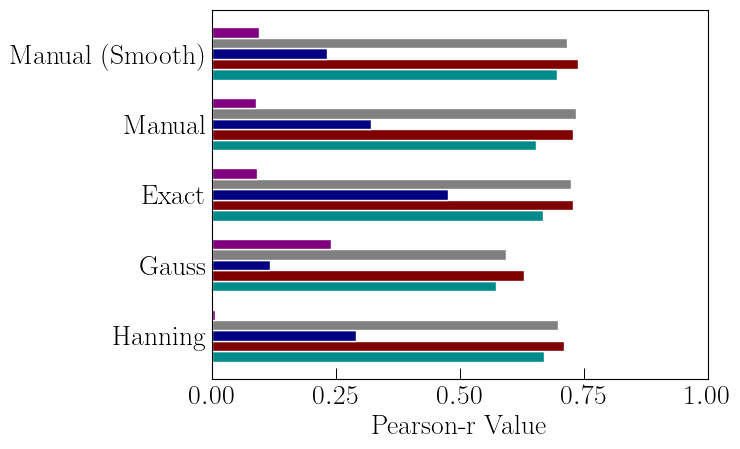

<Figure size 1000x800 with 0 Axes>

In [21]:
# we now wish to plot the found values in a concise manner: will use pandas:
import pandas as pd

rdata = pd.DataFrame({
    "All (26)":[0.670411874,
0.572184798,
0.667371745,
0.653671428,
0.696015325],
    "Just Red":[0.709205623,
0.62944834,
0.728153745,
0.728887292,
0.738960413],
    "Just Blue":[0.289342808,
0.116188872,
0.474833697,
0.319802586,
0.230782572],
    "Just Old":[0.697075838,
0.592932359,
0.724907381,
0.734203833,
0.716627886],
    "Just Young":[0.00514912,
0.240607839,
0.090822137,
0.089077754,
0.094731091],
    }, 
    index=["Hanning", "Gauss", "Exact", "Manual", "Manual (Smooth)"]
)
ax1 = rdata.plot(kind="barh", color=['darkcyan', 'maroon', 'navy','gray', 'purple'], edgecolor='white', zorder=2, width=0.74, legend=False)

#plt.title("Pearson-r Value For Five different Flux Methods and 4 Sub-Samples")
plt.xlabel("Pearson-r Value")
#plt.ylabel("Method")
plt.xlim(-0.001,1.0)
#plt.grid(alpha=0.3,zorder=0)
plt.figure(figsize=(10, 8))
plt.show()


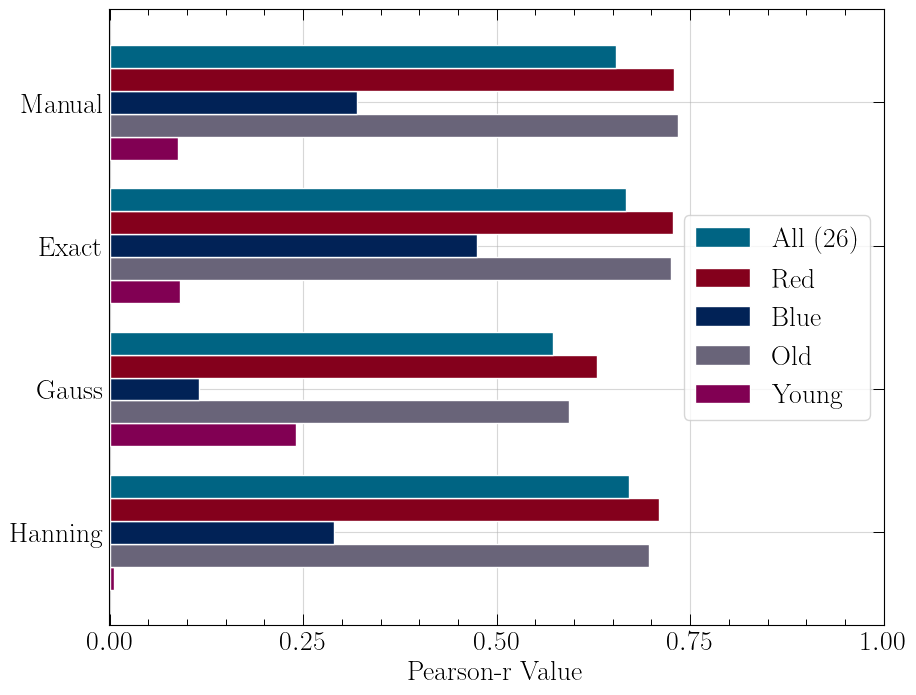

In [22]:
# we now wish to plot the found values in a concise manner: will use pandas:
import pandas as pd

rdata = pd.DataFrame({
    "All (26)":[0.670411874,
0.572184798,
0.667371745,
0.653671428],
    "Red":[0.709205623,
0.62944834,
0.728153745,
0.728887292],
    "Blue":[0.289342808,
0.116188872,
0.474833697,
0.319802586],
    "Old":[0.697075838,
0.592932359,
0.724907381,
0.734203833],
    "Young":[0.00514912,
0.240607839,
0.090822137,
0.089077754],
    }, 
    index=["Hanning", "Gauss", "Exact", "Manual"]
)

rdata_reversed = rdata.iloc[:, ::-1]

colours=['#e69216', '#e4263f', '#2f4b7c','gray', '#d45087']
#colours2=['darkcyan', 'maroon', 'navy','gray', 'purple']
colours2=['#006483', '#84001c', '#012256','#696479', '#810053']#, '#ff5b65']

#ax1 = rdata_reversed.plot(kind="barh", color=colours2[::-1], edgecolor='white', zorder=2, width=0.7)#, legend=False)

#plt.title("Pearson-r Value For Five different Flux Methods and 4 Sub-Samples")

width=10;height=8;ff, ax1 = plt.subplots(1,1, sharex=True, sharey=True);ff.set_figwidth(width);ff.set_figheight(height)

rdata_reversed.plot(kind="barh", color=colours2[::-1], edgecolor='white', zorder=2, width=0.8, ax=ax1)#, legend=False)

#colours2=['#006483', '#84001c', '#012256','#696479', '#810053', '#ff5b65']


ax1.set_xlabel("Pearson-r Value")
#plt.ylabel("Method")
ax1.set_xlim(-0.001,1.0)
#plt.grid(alpha=0.3,zorder=0)
#plt.figure(figsize=(10, 8))
ax1.legend(loc='center right', fontsize='medium')

ax1.xaxis.set_major_locator(MultipleLocator(0.25))
ax1.xaxis.set_minor_locator(MultipleLocator(0.05))
#ax1.yaxis.set_minor_locator(MultipleLocator(0.2))
#ax1.yaxis.set_major_locator(MultipleLocator(1))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
#ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid(True, alpha=0.5, zorder=10)

handles, labels = ax1.get_legend_handles_labels()

# Reverse the order of legend items
handles = handles[::-1]
labels = labels[::-1]

# Create the reversed legend inside the Axes
ax1.legend(handles, labels,loc='center right', fontsize='medium')

#plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/3_pearson_r_4meth_5samps", dpi=250)


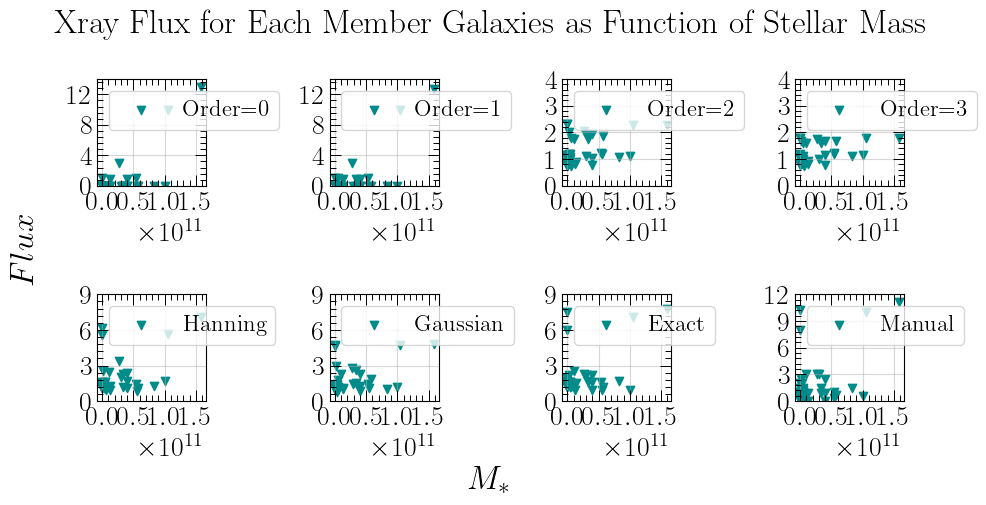

In [23]:
width=10;height=5;ff, ax = plt.subplots(2,4);ff.set_figwidth(width);ff.set_figheight(height);ff.tight_layout(pad=2.5)

ff.suptitle("Xray Flux for Each Member Galaxies as Function of Stellar Mass"); ff.supxlabel(r"$M_{\ast}$"); ff.supylabel(r"$Flux$");

ax[0,0].scatter(10**np.array(mem_data_m37[13]),mem_data_m37[14], marker='v', c='darkcyan', label="Order=0")
ax[0,1].scatter(10**np.array(mem_data_m37[13]),mem_data_m37[15], marker='v', c='darkcyan',label="Order=1")
ax[0,2].scatter(10**np.array(mem_data_m37[13]),mem_data_m37[16], marker='v', c='darkcyan',label="Order=2")
ax[0,3].scatter(10**np.array(mem_data_m37[13]),mem_data_m37[17], marker='v', c='darkcyan',label="Order=3")
ax[1,0].scatter(10**np.array(mem_data_m37[13]),mem_data_m37[18], marker='v', c='darkcyan',label="Hanning")
ax[1,1].scatter(10**np.array(mem_data_m37[13]),mem_data_m37[19], marker='v', c='darkcyan',label="Gaussian")
ax[1,2].scatter(10**np.array(mem_data_m37[13]),mem_data_m37[20], marker='v', c='darkcyan',label="Exact")
ax[1,3].scatter(10**np.array(mem_data_m37[13]),mem_data_m37[21], marker='v', c='darkcyan',label="Manual")


ax[0,0].set_ylim(0,14)
ax[0,1].set_ylim(0,14)
ax[0,2].set_ylim(0,4)
ax[0,3].set_ylim(0,4)
ax[1,0].set_ylim(0,9)
ax[1,1].set_ylim(0,9)
ax[1,2].set_ylim(0,9)
ax[1,3].set_ylim(0,12)


ax[0,0].legend(fontsize='small',loc='upper left');ax[0,1].legend(fontsize='small',loc='upper left');
ax[0,2].legend(fontsize='small',loc='upper left');ax[0,3].legend(fontsize='small',loc='upper left');
ax[1,0].legend(fontsize='small',loc='upper left');ax[1,1].legend(fontsize='small',loc='upper left');
ax[1,2].legend(fontsize='small', loc='upper left'); ax[1,3].legend(fontsize='small', loc='upper left');


ax[0,0].yaxis.set_minor_locator(MultipleLocator(0.8));ax[0,0].yaxis.set_major_locator(MultipleLocator(4))
ax[0,0].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[0,0].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[0,0].tick_params(axis='both', direction="in");
ax[0,0].tick_params(which="minor", axis="x", direction="in");ax[0,0].tick_params(which="minor", axis="y", direction="in")
ax[0,0].xaxis.set_ticks_position('both') ;ax[0,0].yaxis.set_ticks_position('both')
ax[0,0].grid(True, alpha=0.5, zorder=10)

ax[0,1].yaxis.set_minor_locator(MultipleLocator(0.8));ax[0,1].yaxis.set_major_locator(MultipleLocator(4))
ax[0,1].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[0,1].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[0,1].tick_params(axis='both', direction="in")
ax[0,1].tick_params(which="minor", axis="x", direction="in");ax[0,1].tick_params(which="minor", axis="y", direction="in")
ax[0,1].xaxis.set_ticks_position('both') ;ax[0,1].yaxis.set_ticks_position('both')
ax[0,1].grid(True, alpha=0.5, zorder=10)

ax[0,2].yaxis.set_minor_locator(MultipleLocator(0.2));ax[0,2].yaxis.set_major_locator(MultipleLocator(1))
ax[0,2].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[0,2].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[0,2].tick_params(axis='both', direction="in")
ax[0,2].tick_params(which="minor", axis="x", direction="in");ax[0,2].tick_params(which="minor", axis="y", direction="in")
ax[0,2].xaxis.set_ticks_position('both') ;ax[0,2].yaxis.set_ticks_position('both')
ax[0,2].grid(True, alpha=0.5, zorder=10)

ax[0,3].yaxis.set_minor_locator(MultipleLocator(0.2));ax[0,3].yaxis.set_major_locator(MultipleLocator(1))
ax[0,3].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[0,3].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[0,3].tick_params(axis='both', direction="in")
ax[0,3].tick_params(which="minor", axis="x", direction="in");ax[0,3].tick_params(which="minor", axis="y", direction="in")
ax[0,3].xaxis.set_ticks_position('both') ;ax[0,3].yaxis.set_ticks_position('both')
ax[0,3].grid(True, alpha=0.5, zorder=10)

ax[1,0].yaxis.set_minor_locator(MultipleLocator(0.6));ax[1,0].yaxis.set_major_locator(MultipleLocator(3))
ax[1,0].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[1,0].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[1,0].tick_params(axis='both', direction="in")
ax[1,0].tick_params(which="minor", axis="x", direction="in");ax[1,0].tick_params(which="minor", axis="y", direction="in")
ax[1,0].xaxis.set_ticks_position('both') ;ax[0,3].yaxis.set_ticks_position('both')
ax[1,0].grid(True, alpha=0.5, zorder=10)

ax[1,1].yaxis.set_minor_locator(MultipleLocator(0.6));ax[1,1].yaxis.set_major_locator(MultipleLocator(3))
ax[1,1].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[1,1].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[1,1].tick_params(axis='both', direction="in")
ax[1,1].tick_params(which="minor", axis="x", direction="in");ax[1,1].tick_params(which="minor", axis="y", direction="in")
ax[1,1].xaxis.set_ticks_position('both') ;ax[0,3].yaxis.set_ticks_position('both')
ax[1,1].grid(True, alpha=0.5, zorder=10)

ax[1,2].yaxis.set_minor_locator(MultipleLocator(0.6));ax[1,2].yaxis.set_major_locator(MultipleLocator(3))
ax[1,2].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[1,2].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[1,2].tick_params(axis='both', direction="in")
ax[1,2].tick_params(which="minor", axis="x", direction="in");ax[1,2].tick_params(which="minor", axis="y", direction="in")
ax[1,2].xaxis.set_ticks_position('both') ;ax[1,2].yaxis.set_ticks_position('both')
ax[1,2].grid(True, alpha=0.5, zorder=10)

ax[1,3].yaxis.set_minor_locator(MultipleLocator(0.6));ax[1,3].yaxis.set_major_locator(MultipleLocator(3))
ax[1,3].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[1,3].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[1,3].tick_params(axis='both', direction="in")
ax[1,3].tick_params(which="minor", axis="x", direction="in");ax[1,3].tick_params(which="minor", axis="y", direction="in")
ax[1,3].xaxis.set_ticks_position('both') ;ax[1,2].yaxis.set_ticks_position('both')
ax[1,3].grid(True, alpha=0.5, zorder=10)

Text(-10000000000.0, 10.2, 'Manual')

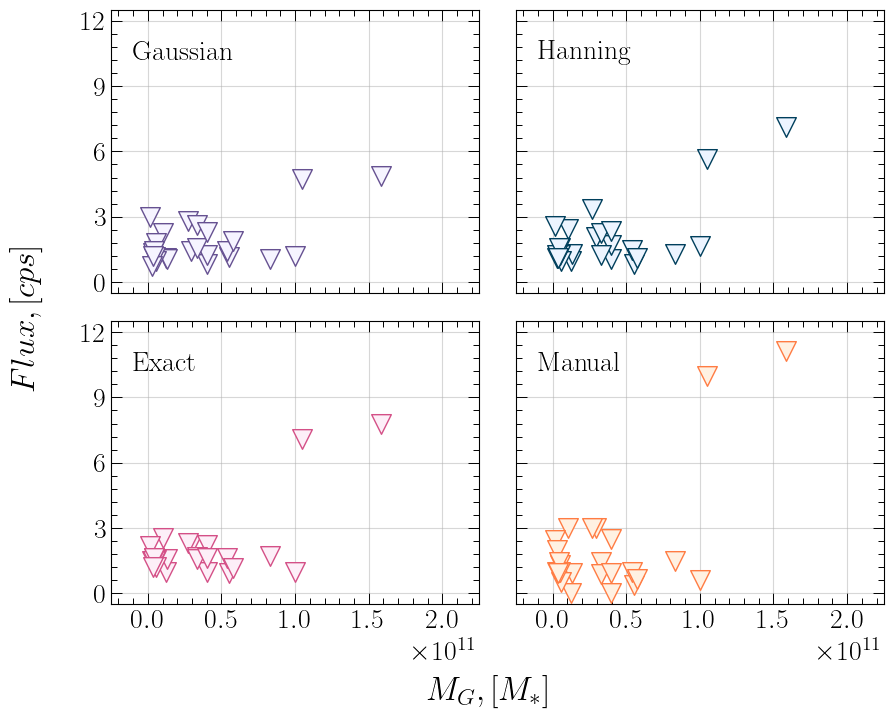

In [24]:
width=10;height=8;ff, ax = plt.subplots(2,2);ff.set_figwidth(width);ff.set_figheight(height);ff.tight_layout(pad=3)

ff.supxlabel(r"$M_G, [M_{\ast}]$"); ff.supylabel(r"$Flux, [cps]$");

ax[0,1].scatter(10**np.array(mem_data_m26[13]),mem_data_m26[18], marker='v',c='#ecf4ff', edgecolor='#003f5c',label="Hanning", s=200, zorder=10)
ax[0,0].scatter(10**np.array(mem_data_m26[13]),mem_data_m26[19], marker='v',c='#f6f4ff', edgecolor='#665191',label="Gaussian",s=200, zorder=10)
ax[1,0].scatter(10**np.array(mem_data_m26[13]),mem_data_m26[20], marker='v',c='#fdeff8', edgecolor='#d45087',label="Exact",   s=200, zorder=10)
ax[1,1].scatter(10**np.array(mem_data_m26[13]),mem_data_m26[21], marker='v',c='#fff1e2', edgecolor='#ff7c43',label="Manual",  s=200, zorder=10)


ax[0,0].set_ylim(-0.5,12.5)
ax[0,1].set_ylim(-0.5,12.5)
ax[1,0].set_ylim(-0.5,12.5)
ax[1,1].set_ylim(-0.5,12.5)
ax[0,0].set_xlim(-0.25e11,2.25e11)
ax[0,1].set_xlim(-0.25e11,2.25e11)
ax[1,0].set_xlim(-0.25e11,2.25e11)
ax[1,1].set_xlim(-0.25e11,2.25e11)

# ax[0,0].legend(fontsize='small',loc='upper right');
# ax[0,1].legend(fontsize='small',loc='upper right');
# ax[1,0].legend(fontsize='small',loc='lower right');
# ax[1,1].legend(fontsize='small',loc='lower right');



ax[0,0].yaxis.set_minor_locator(MultipleLocator(0.6));
ax[0,0].yaxis.set_major_locator(MultipleLocator(3))
ax[0,0].xaxis.set_minor_locator(MultipleLocator(0.1e11));
ax[0,0].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[0,0].tick_params(axis='both', direction="in")
ax[0,0].tick_params(which="minor", axis="x", direction="in");
ax[0,0].tick_params(which="minor", axis="y", direction="in")
ax[0,0].xaxis.set_ticks_position('both') ;
ax[0,0].yaxis.set_ticks_position('both')
ax[0,0].grid(True, alpha=0.5, zorder=10)

ax[0,1].yaxis.set_minor_locator(MultipleLocator(0.6));
ax[0,1].yaxis.set_major_locator(MultipleLocator(3))
ax[0,1].xaxis.set_minor_locator(MultipleLocator(0.1e11));
ax[0,1].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[0,1].tick_params(axis='both', direction="in")
ax[0,1].tick_params(which="minor", axis="x", direction="in");
ax[0,1].tick_params(which="minor", axis="y", direction="in")
ax[0,1].xaxis.set_ticks_position('both') ;
ax[0,1].yaxis.set_ticks_position('both')
ax[0,1].grid(True, alpha=0.5, zorder=10)

ax[1,0].yaxis.set_minor_locator(MultipleLocator(0.6));
ax[1,0].yaxis.set_major_locator(MultipleLocator(3))
ax[1,0].xaxis.set_minor_locator(MultipleLocator(0.1e11));
ax[1,0].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[1,0].tick_params(axis='both', direction="in")
ax[1,0].tick_params(which="minor", axis="x", direction="in");
ax[1,0].tick_params(which="minor", axis="y", direction="in")
ax[1,0].xaxis.set_ticks_position('both') ;
ax[1,0].yaxis.set_ticks_position('both')
ax[1,0].grid(True, alpha=0.5, zorder=10)

ax[1,1].yaxis.set_minor_locator(MultipleLocator(0.6));
ax[1,1].yaxis.set_major_locator(MultipleLocator(3))
ax[1,1].xaxis.set_minor_locator(MultipleLocator(0.1e11));
ax[1,1].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[1,1].tick_params(axis='both', direction="in")
ax[1,1].tick_params(which="minor", axis="x", direction="in");
ax[1,1].tick_params(which="minor", axis="y", direction="in")
ax[1,1].xaxis.set_ticks_position('both') ;
ax[1,1].yaxis.set_ticks_position('both')
ax[1,1].grid(True, alpha=0.5, zorder=10)
plt.subplots_adjust(wspace=0.1) 
plt.subplots_adjust(hspace=0.1) 




ax[1,1].set_yticklabels([])
ax[0,1].set_yticklabels([])

ax[0,1].set_xticklabels([])
ax[0,0].set_xticklabels([])


ax[0,0].text(-0.1e11, 10.2, 'Gaussian', c='k', weight='bold',   fontsize=20)
ax[0,1].text(-0.1e11, 10.2, 'Hanning', c='k',      weight='bold',fontsize=20)
ax[1,0].text(-0.1e11, 10.2, 'Exact', c='k',    weight='bold',    fontsize=20)
ax[1,1].text(-0.1e11, 10.2, 'Manual', c='k',      weight='bold', fontsize=20)
# 1

#plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/2_mass_flux_methods", dpi=250)


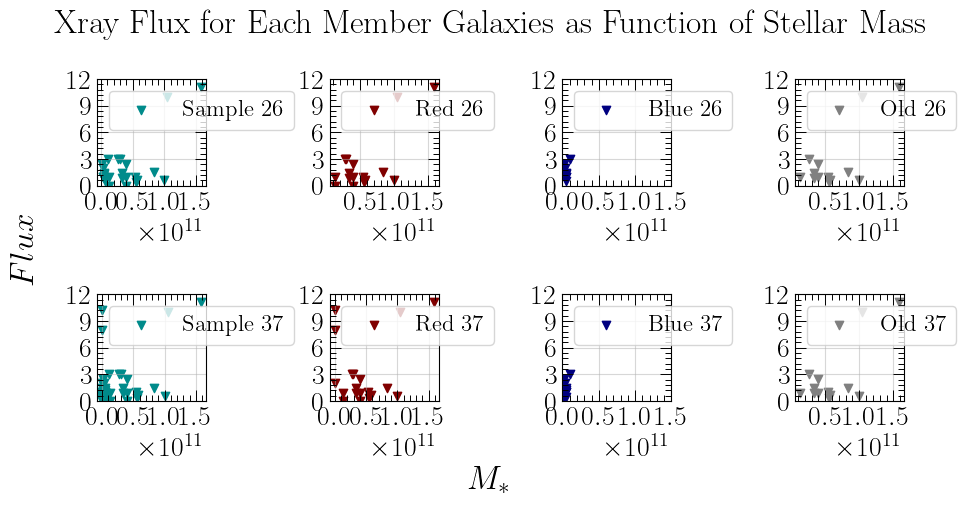

In [25]:
width=10;height=5;ff, ax = plt.subplots(2,4);ff.set_figwidth(width);ff.set_figheight(height);ff.tight_layout(pad=2.5)

ff.suptitle("Xray Flux for Each Member Galaxies as Function of Stellar Mass"); ff.supxlabel(r"$M_{\ast}$"); ff.supylabel(r"$Flux$");

ax[0,0].scatter(10**np.array(mem_data_m26[13]),mem_data_m26[21], marker='v', c='darkcyan', label="Sample 26")
ax[0,1].scatter(10**np.array(red_m26[13]),red_m26[21], marker='v', c='maroon',label="Red 26")
ax[0,2].scatter(10**np.array(blue_m26[13]),blue_m26[21], marker='v', c='navy',label="Blue 26")
ax[0,3].scatter(10**np.array(old_m26[13]),old_m26[21], marker='v', c='grey',label="Old 26")
ax[1,0].scatter(10**np.array(mem_data_m37[13]),mem_data_m37[21], marker='v', c='darkcyan',label="Sample 37")
ax[1,1].scatter(10**np.array(red_m37[13]),red_m37[21], marker='v', c='maroon',label="Red 37")
ax[1,2].scatter(10**np.array(blue_m37[13]),blue_m37[21], marker='v', c='navy',label="Blue 37")
ax[1,3].scatter(10**np.array(old_m37[13]),old_m37[21], marker='v', c='grey',label="Old 37")


ax[0,0].set_ylim(0,12)
ax[0,1].set_ylim(0,12)
ax[0,2].set_ylim(0,12);ax[0,2].set_xlim(0,1.5e11)
ax[0,3].set_ylim(0,12)
ax[1,0].set_ylim(0,12)
ax[1,1].set_ylim(0,12)
ax[1,2].set_ylim(0,12);ax[1,2].set_xlim(0,1.5e11)
ax[1,3].set_ylim(0,12)


ax[0,0].legend(fontsize='small',loc='upper left');ax[0,1].legend(fontsize='small',loc='upper left');
ax[0,2].legend(fontsize='small',loc='upper left');ax[0,3].legend(fontsize='small',loc='upper left');
ax[1,0].legend(fontsize='small',loc='upper left');ax[1,1].legend(fontsize='small',loc='upper left');
ax[1,2].legend(fontsize='small', loc='upper left'); ax[1,3].legend(fontsize='small', loc='upper left');


ax[0,0].yaxis.set_minor_locator(MultipleLocator(0.6));ax[0,0].yaxis.set_major_locator(MultipleLocator(3))
ax[0,0].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[0,0].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[0,0].tick_params(axis='both', direction="in");
ax[0,0].tick_params(which="minor", axis="x", direction="in");ax[0,0].tick_params(which="minor", axis="y", direction="in")
ax[0,0].xaxis.set_ticks_position('both') ;ax[0,0].yaxis.set_ticks_position('both')
ax[0,0].grid(True, alpha=0.5, zorder=10)

ax[0,1].yaxis.set_minor_locator(MultipleLocator(0.6));ax[0,1].yaxis.set_major_locator(MultipleLocator(3))
ax[0,1].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[0,1].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[0,1].tick_params(axis='both', direction="in")
ax[0,1].tick_params(which="minor", axis="x", direction="in");ax[0,1].tick_params(which="minor", axis="y", direction="in")
ax[0,1].xaxis.set_ticks_position('both') ;ax[0,1].yaxis.set_ticks_position('both')
ax[0,1].grid(True, alpha=0.5, zorder=10)

ax[0,2].yaxis.set_minor_locator(MultipleLocator(0.6));ax[0,2].yaxis.set_major_locator(MultipleLocator(3))
ax[0,2].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[0,2].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[0,2].tick_params(axis='both', direction="in")
ax[0,2].tick_params(which="minor", axis="x", direction="in");ax[0,2].tick_params(which="minor", axis="y", direction="in")
ax[0,2].xaxis.set_ticks_position('both') ;ax[0,2].yaxis.set_ticks_position('both')
ax[0,2].grid(True, alpha=0.5, zorder=10)

ax[0,3].yaxis.set_minor_locator(MultipleLocator(0.6));ax[0,3].yaxis.set_major_locator(MultipleLocator(3))
ax[0,3].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[0,3].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[0,3].tick_params(axis='both', direction="in")
ax[0,3].tick_params(which="minor", axis="x", direction="in");ax[0,3].tick_params(which="minor", axis="y", direction="in")
ax[0,3].xaxis.set_ticks_position('both') ;ax[0,3].yaxis.set_ticks_position('both')
ax[0,3].grid(True, alpha=0.5, zorder=10)

ax[1,0].yaxis.set_minor_locator(MultipleLocator(0.6));ax[1,0].yaxis.set_major_locator(MultipleLocator(3))
ax[1,0].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[1,0].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[1,0].tick_params(axis='both', direction="in")
ax[1,0].tick_params(which="minor", axis="x", direction="in");ax[1,0].tick_params(which="minor", axis="y", direction="in")
ax[1,0].xaxis.set_ticks_position('both') ;ax[0,3].yaxis.set_ticks_position('both')
ax[1,0].grid(True, alpha=0.5, zorder=10)

ax[1,1].yaxis.set_minor_locator(MultipleLocator(0.6));ax[1,1].yaxis.set_major_locator(MultipleLocator(3))
ax[1,1].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[1,1].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[1,1].tick_params(axis='both', direction="in")
ax[1,1].tick_params(which="minor", axis="x", direction="in");ax[1,1].tick_params(which="minor", axis="y", direction="in")
ax[1,1].xaxis.set_ticks_position('both') ;ax[0,3].yaxis.set_ticks_position('both')
ax[1,1].grid(True, alpha=0.5, zorder=10)

ax[1,2].yaxis.set_minor_locator(MultipleLocator(0.6));ax[1,2].yaxis.set_major_locator(MultipleLocator(3))
ax[1,2].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[1,2].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[1,2].tick_params(axis='both', direction="in")
ax[1,2].tick_params(which="minor", axis="x", direction="in");ax[1,2].tick_params(which="minor", axis="y", direction="in")
ax[1,2].xaxis.set_ticks_position('both') ;ax[1,2].yaxis.set_ticks_position('both')
ax[1,2].grid(True, alpha=0.5, zorder=10)

ax[1,3].yaxis.set_minor_locator(MultipleLocator(0.6));ax[1,3].yaxis.set_major_locator(MultipleLocator(3))
ax[1,3].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[1,3].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[1,3].tick_params(axis='both', direction="in")
ax[1,3].tick_params(which="minor", axis="x", direction="in");ax[1,3].tick_params(which="minor", axis="y", direction="in")
ax[1,3].xaxis.set_ticks_position('both') ;ax[1,3].yaxis.set_ticks_position('both')
ax[1,3].grid(True, alpha=0.5, zorder=10)

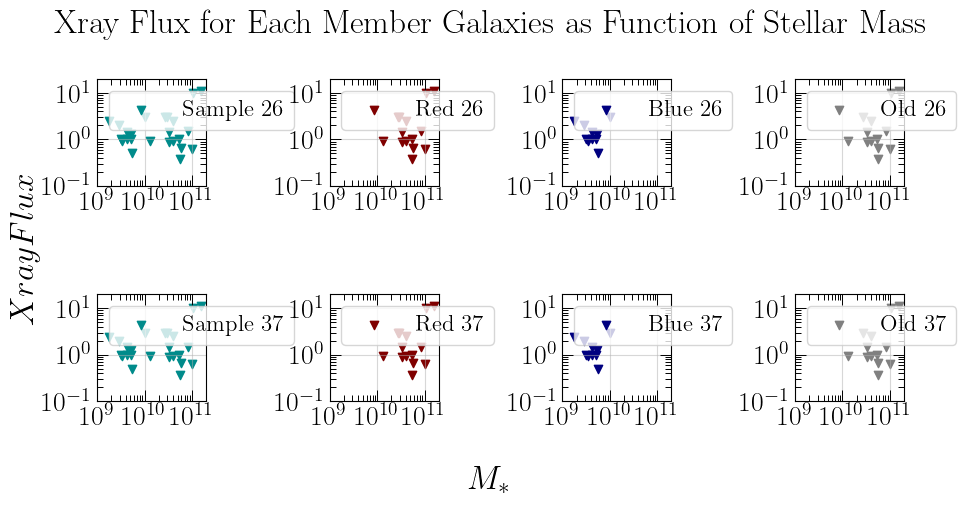

In [26]:
width=10;height=5;ff, ax = plt.subplots(2,4);ff.set_figwidth(width);ff.set_figheight(height);ff.tight_layout(pad=2.5)

ff.suptitle("Xray Flux for Each Member Galaxies as Function of Stellar Mass"); ff.supxlabel(r"$M_{\ast}$"); ff.supylabel(r"$Xray Flux$");

ax[0,0].scatter(10**np.array(mem_data_m26[13]),mem_data_m26[21], marker='v', c='darkcyan', label="Sample 26")
ax[0,1].scatter(10**np.array(red_m26[13]),red_m26[21], marker='v', c='maroon',label="Red 26")
ax[0,2].scatter(10**np.array(blue_m26[13]),blue_m26[21], marker='v', c='navy',label="Blue 26")
ax[0,3].scatter(10**np.array(old_m26[13]),old_m26[21], marker='v', c='grey',label="Old 26")
ax[1,0].scatter(10**np.array(mem_data_m37[13]),mem_data_m37[21], marker='v', c='darkcyan',label="Sample 37")
ax[1,1].scatter(10**np.array(red_m37[13]),red_m37[21], marker='v', c='maroon',label="Red 37")
ax[1,2].scatter(10**np.array(blue_m37[13]),blue_m37[21], marker='v', c='navy',label="Blue 37")
ax[1,3].scatter(10**np.array(old_m37[13]),old_m37[21], marker='v', c='grey',label="Old 37")


ax[0,0].set_ylim(0.1,20);ax[0,0].set_xlim(1e9,2e11)
ax[0,1].set_ylim(0.1,20);ax[0,1].set_xlim(1e9,2e11)
ax[0,2].set_ylim(0.1,20);ax[0,2].set_xlim(1e9,2e11)
ax[0,3].set_ylim(0.1,20);ax[0,3].set_xlim(1e9,2e11)
ax[1,0].set_ylim(0.1,20);ax[1,0].set_xlim(1e9,2e11)
ax[1,1].set_ylim(0.1,20);ax[1,1].set_xlim(1e9,2e11)
ax[1,2].set_ylim(0.1,20);ax[1,2].set_xlim(1e9,2e11)
ax[1,3].set_ylim(0.1,20);ax[1,3].set_xlim(1e9,2e11)


ax[0,0].legend(fontsize='small',loc='upper left');ax[0,1].legend(fontsize='small',loc='upper left');
ax[0,2].legend(fontsize='small',loc='upper left');ax[0,3].legend(fontsize='small',loc='upper left');
ax[1,0].legend(fontsize='small',loc='upper left');ax[1,1].legend(fontsize='small',loc='upper left');
ax[1,2].legend(fontsize='small', loc='upper left'); ax[1,3].legend(fontsize='small', loc='upper left');


ax[0,0].yaxis.set_minor_locator(MultipleLocator(0.6));ax[0,0].yaxis.set_major_locator(MultipleLocator(3))
ax[0,0].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[0,0].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[0,0].tick_params(axis='both', direction="in");
ax[0,0].tick_params(which="minor", axis="x", direction="in");ax[0,0].tick_params(which="minor", axis="y", direction="in")
ax[0,0].xaxis.set_ticks_position('both') ;ax[0,0].yaxis.set_ticks_position('both')
ax[0,0].grid(True, alpha=0.5, zorder=10)

ax[0,1].yaxis.set_minor_locator(MultipleLocator(0.6));ax[0,1].yaxis.set_major_locator(MultipleLocator(3))
ax[0,1].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[0,1].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[0,1].tick_params(axis='both', direction="in")
ax[0,1].tick_params(which="minor", axis="x", direction="in");ax[0,1].tick_params(which="minor", axis="y", direction="in")
ax[0,1].xaxis.set_ticks_position('both') ;ax[0,1].yaxis.set_ticks_position('both')
ax[0,1].grid(True, alpha=0.5, zorder=10)

ax[0,2].yaxis.set_minor_locator(MultipleLocator(0.6));ax[0,2].yaxis.set_major_locator(MultipleLocator(3))
ax[0,2].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[0,2].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[0,2].tick_params(axis='both', direction="in")
ax[0,2].tick_params(which="minor", axis="x", direction="in");ax[0,2].tick_params(which="minor", axis="y", direction="in")
ax[0,2].xaxis.set_ticks_position('both') ;ax[0,2].yaxis.set_ticks_position('both')
ax[0,2].grid(True, alpha=0.5, zorder=10)

ax[0,3].yaxis.set_minor_locator(MultipleLocator(0.6));ax[0,3].yaxis.set_major_locator(MultipleLocator(3))
ax[0,3].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[0,3].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[0,3].tick_params(axis='both', direction="in")
ax[0,3].tick_params(which="minor", axis="x", direction="in");ax[0,3].tick_params(which="minor", axis="y", direction="in")
ax[0,3].xaxis.set_ticks_position('both') ;ax[0,3].yaxis.set_ticks_position('both')
ax[0,3].grid(True, alpha=0.5, zorder=10)

ax[1,0].yaxis.set_minor_locator(MultipleLocator(0.6));ax[1,0].yaxis.set_major_locator(MultipleLocator(3))
ax[1,0].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[1,0].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[1,0].tick_params(axis='both', direction="in")
ax[1,0].tick_params(which="minor", axis="x", direction="in");ax[1,0].tick_params(which="minor", axis="y", direction="in")
ax[1,0].xaxis.set_ticks_position('both') ;ax[0,3].yaxis.set_ticks_position('both')
ax[1,0].grid(True, alpha=0.5, zorder=10)

ax[1,1].yaxis.set_minor_locator(MultipleLocator(0.6));ax[1,1].yaxis.set_major_locator(MultipleLocator(3))
ax[1,1].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[1,1].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[1,1].tick_params(axis='both', direction="in")
ax[1,1].tick_params(which="minor", axis="x", direction="in");ax[1,1].tick_params(which="minor", axis="y", direction="in")
ax[1,1].xaxis.set_ticks_position('both') ;ax[0,3].yaxis.set_ticks_position('both')
ax[1,1].grid(True, alpha=0.5, zorder=10)

ax[1,2].yaxis.set_minor_locator(MultipleLocator(0.6));ax[1,2].yaxis.set_major_locator(MultipleLocator(3))
ax[1,2].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[1,2].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[1,2].tick_params(axis='both', direction="in")
ax[1,2].tick_params(which="minor", axis="x", direction="in");ax[1,2].tick_params(which="minor", axis="y", direction="in")
ax[1,2].xaxis.set_ticks_position('both') ;ax[1,2].yaxis.set_ticks_position('both')
ax[1,2].grid(True, alpha=0.5, zorder=10)

ax[1,3].yaxis.set_minor_locator(MultipleLocator(0.6));ax[1,3].yaxis.set_major_locator(MultipleLocator(3))
ax[1,3].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[1,3].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[1,3].tick_params(axis='both', direction="in")
ax[1,3].tick_params(which="minor", axis="x", direction="in");ax[1,3].tick_params(which="minor", axis="y", direction="in")
ax[1,3].xaxis.set_ticks_position('both') ;ax[1,3].yaxis.set_ticks_position('both')
ax[1,3].grid(True, alpha=0.5, zorder=10)

ax[0,0].set_xscale('log');ax[0,1].set_xscale('log')
ax[0,2].set_xscale('log');ax[0,3].set_xscale('log')
ax[1,0].set_xscale('log');ax[1,1].set_xscale('log')
ax[1,2].set_xscale('log');ax[1,3].set_xscale('log')

ax[0,0].set_yscale('log');ax[0,1].set_yscale('log')
ax[0,2].set_yscale('log');ax[0,3].set_yscale('log')
ax[1,0].set_yscale('log');ax[1,1].set_yscale('log')
ax[1,2].set_yscale('log');ax[1,3].set_yscale('log')

0.033245055650206155 0.914140798210254


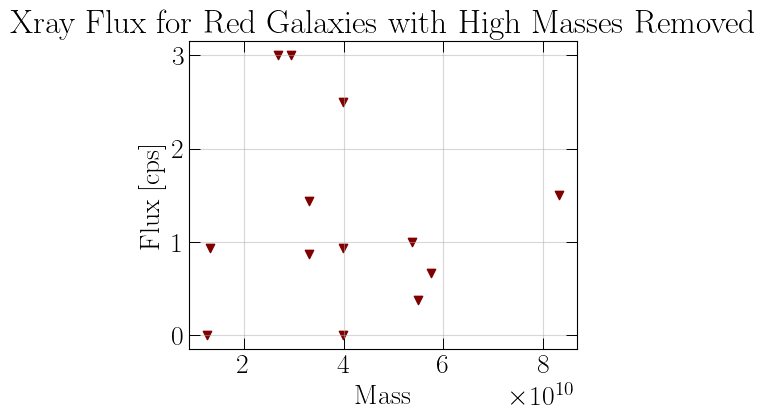

In [27]:
# with high mass removed:

high_mrem_m26 = [red_m26[13][i] for i in range(len(red_m26[13])) if 10**np.array(red_m26[13][i])<= 0.9e11]
high_frem_m26 = [red_m26[21][i] for i in range(len(red_m26[13])) if 10**np.array(red_m26[13][i])<=0.9e11]              
                 
rem_r_m26, rem_p_m26 = sp.stats.pearsonr(high_mrem_m26,high_frem_m26)

print(rem_r_m26, rem_p_m26)


# we can now plot mass against magnitude:

width=5;height=4;ff, ax1 = plt.subplots(1,1, sharex=True, sharey=True);ff.set_figwidth(width);ff.set_figheight(height)

#ax1.set_xlim(20,25)
#ax1.set_ylim(8,12)
ax1.set_title("Xray Flux for Red Galaxies with High Masses Removed")
ax1.set_ylabel(r"Flux [cps]")
ax1.set_xlabel(r"Mass")

ax1.scatter(10**np.array(high_mrem_m26),high_frem_m26, marker='v', c='maroon')

#ax1.xaxis.set_major_locator(MultipleLocator(1))
#ax1.xaxis.set_minor_locator(MultipleLocator(0.2))
#ax1.yaxis.set_minor_locator(MultipleLocator(0.2))
#ax1.yaxis.set_major_locator(MultipleLocator(1))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid(True, alpha=0.5, zorder=10)


plt.show()

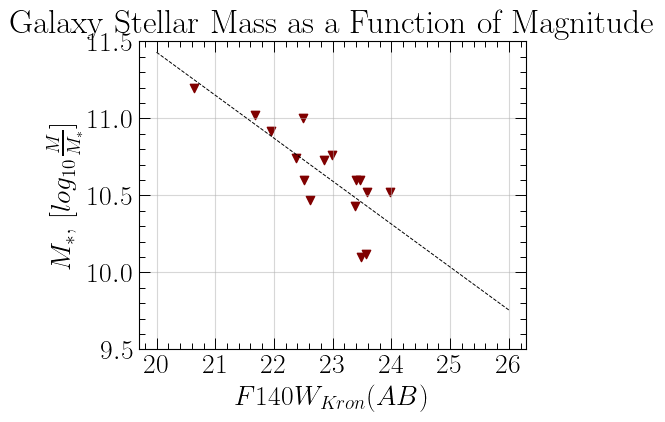

In [28]:
# we can now plot mass against magnitude for only the red objects:

width=5;height=4;ff, ax1 = plt.subplots(1,1, sharex=True, sharey=True);ff.set_figwidth(width);ff.set_figheight(height)
#ax1.set_xlim(20,25)
ax1.set_ylim(9.5,11.5)
ax1.set_title("Galaxy Stellar Mass as a Function of Magnitude")
ax1.set_ylabel(r"$M_{\ast}$, $[log_{10}\frac{M}{M_{\ast}}]$")
ax1.set_xlabel(r"$F140W_{Kron}(AB)$")

ax1.scatter(red_m26[4], red_m26[13], marker='v', c='maroon')

ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.xaxis.set_minor_locator(MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(MultipleLocator(0.1))
ax1.yaxis.set_major_locator(MultipleLocator(0.5))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid(True, alpha=0.5, zorder=10)
m_red, b_red = np.polyfit(red_m26[4], red_m26[13],1)
xx = np.linspace(20,26,100)

ax1.plot(xx,m_red*xx+b_red,color='k',linestyle='--',linewidth=0.7)

plt.show()

In [29]:
# now we need to generate the extrapolated masses from the above fit:

pot_masses = np.array([(pot_members[7][i] * m_red +b_red) for i in range(len(pot_members[0]))]) # log10(M)
pot_path = '/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/potential_members.csv'
pot_members = np.loadtxt(pot_path, skiprows=1, delimiter=',', dtype='float', encoding='latin-1').T


In [32]:
# we can now go about adding the red, faint objects to our sample in a number of ways.
# The first involves selecting a fraction of the objects at random with the fraction motivated
# by the spectroscopically resolved red object ratios:

# rough estimate percentages of the population:
N_silver = 1; N_gold = 19; N_fg = 5; N_sc = 3; N_pot = 1
c_samp= N_silver+ N_gold+ N_fg+ N_sc+ N_pot; mem_N = N_silver+N_gold

silv_per = N_silver/c_samp*100; gold_per = N_gold/c_samp*100; mem_per = mem_N/c_samp*100; 
fg_per = N_fg/c_samp*100

print(f'{silv_per:0.5f}%',f'{gold_per:0.5f}%', f'{mem_per:0.5f}%')
print(fg_per)
print(c_samp)

3.44828% 65.51724% 68.96552%
17.24137931034483
29


In [39]:
20/29


0.6896551724137931

In [33]:
# to do this, we will run a proof of concept first by selecting ~ 70% of the potential members and then 
# correlating their xray flux with their mass:

import random

pot_members_T = list(pot_members.T)

# need to establish a rough estimate of ratios motivated by the above:

samp_size = 61 # number of galaxies to select each time

print(f'{(samp_size-1)/len(pot_members_T):0.4f}',f'{samp_size/len(pot_members_T):0.4f}',f'{(samp_size+1)/len(pot_members_T):0.4f}')

# now we select samp_size items from the potential members:

pot_sample = np.array(random.sample(pot_members_T, samp_size))

# mass is found at index 22, xray flux at index 23:

samp_r, samp_p = sp.stats.pearsonr(pot_sample.T[22], pot_sample.T[23])

# now we need a function to perform this as many times as we want:

def faint_red_rdist(data=pot_members_T, ss=61, NUM=1, with_mem = True):
    
    data_T = np.array(data).T
    r_values = np.zeros(NUM); p_values = np.zeros(NUM)
    
    avg_r = np.zeros(len(data)); avg_p = np.zeros(len(data))
    num_r = np.zeros(len(data)); num_p = np.zeros(len(data))
    
    pot_ID = data_T[16]
    
    if with_mem ==False:
        print("Members = False")
        for i in range(NUM):
    
            pot_sample = np.array(random.sample(data, ss))
        
            samp_ID = np.array(pot_sample).T[16]
            samp_r,samp_p = sp.stats.pearsonr(10**pot_sample.T[22], pot_sample.T[23])
        
            r_values[i] = samp_r; p_values[i] = samp_p
            for i in samp_ID:
                idx =np.where(data_T[16] ==i)[0]
                avg_r[idx] +=samp_r;avg_p[idx] +=samp_p; 
                num_r[idx] += 1; num_p[idx] +=1
    else:
        print("Members = True")
        for i in range(NUM):
    
            pot_sample = np.array(random.sample(data, ss))
        
            samp_ID = np.array(pot_sample).T[16]
            samp_mass = list(10**pot_sample.T[22])
            samp_flux = list(pot_sample.T[23])
            
            mass = samp_mass + list(10**red_m26[13])
            flux = samp_flux + list(red_m26[21])
            samp_r,samp_p = sp.stats.pearsonr(10**pot_sample.T[22], pot_sample.T[23])
        
            r_values[i] = samp_r; p_values[i] = samp_p
            for i in samp_ID:
                idx =np.where(data_T[16] ==i)[0]
                avg_r[idx] +=samp_r;avg_p[idx] +=samp_p; 
                num_r[idx] += 1; num_p[idx] +=1

    return [r_values, p_values, np.array(avg_r)/np.array(num_r), np.array(avg_p)/np.array(num_p)]

0.6742 0.6854 0.6966


In [34]:
print(len(pot_members_T))

89


In [244]:
# now we can run this for as many sets of samples as we want:

# number of samples:
NS = 100000

# r distributions:

#r_100k, p_100k, avgr_100k, avgp_100k = faint_red_rdist(NUM=NS, with_mem=True)

Members = True


In [267]:
def get_top_percentage(values, percentage):
    num_values = int(len(values) * percentage)
    top_values = sorted(values, key=lambda x: -x)[:num_values]
    return top_values

# Example usage:
my_list = [10, 20, 5, 30, 15, 25, 35]
percentage = 0.4  # You can adjust this value according to your needs

result = get_top_percentage(avgr_100k,0.689655)
print(min(result))

0.32903112116004324


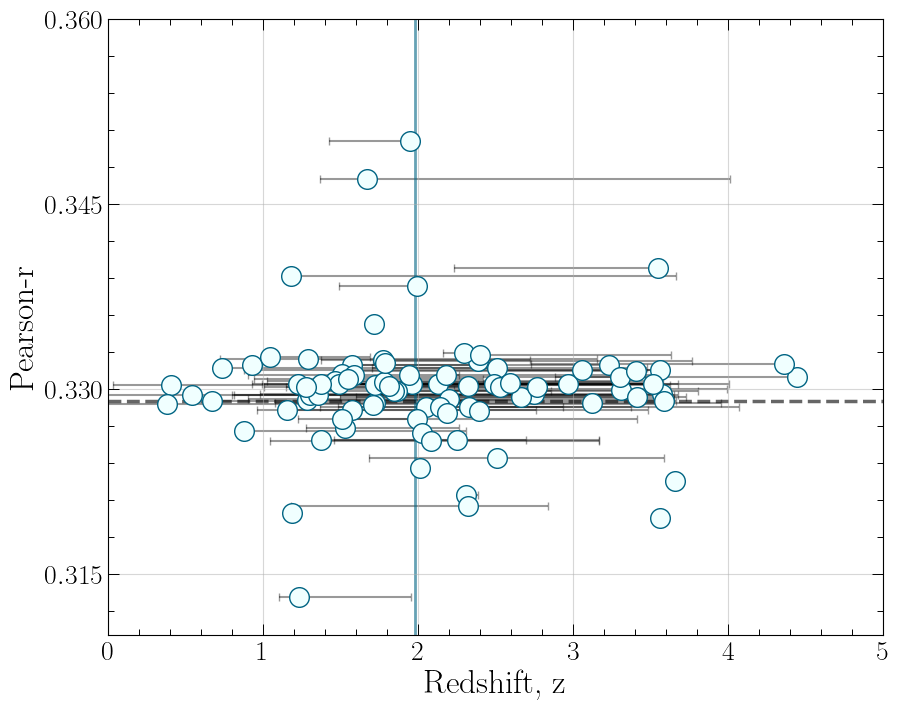

In [464]:

width=10;height=8;ff, ax1 = plt.subplots(1,1, sharex=True, sharey=True);ff.set_figwidth(width);ff.set_figheight(height)

ax1.set_xlim(0,5)
ax1.set_ylim(0.31, 0.36)
#ax1.set_title("Galaxy Stellar Mass as a Function of Magnitude")
ax1.set_ylabel(r"Pearson-r",fontsize=24)
ax1.set_xlabel(r"Redshift, z",fontsize=24)

ax1.scatter(np.array(pot_members)[12], avgr_100k, color='azure', edgecolor=colours2[0],zorder=5,alpha=1,s=200)

ax1.errorbar(np.array(pot_members)[12], avgr_100k, xerr=[np.abs(np.array(pot_members)[12]-np.array(pot_members)[13]),np.abs(np.array(pot_members)[14]-np.array(pot_members)[12])],
             c='k', alpha=0.4, fmt='o', zorder=0,ecolor='black',capsize=3)

ax1.axvline(1.98, c=colours2[0], linestyle = '-', alpha=0.6,zorder=0,linewidth=2)

ax1.axhline(min(result), c='k', linestyle = '--', alpha=0.6,zorder=0,linewidth=2.5)


ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.xaxis.set_minor_locator(MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(MultipleLocator(0.003))
ax1.yaxis.set_major_locator(MultipleLocator(0.015))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid(True, alpha=0.5, zorder=10)

plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/3_sample_extension_spaceship", dpi=250)


In [236]:
def get_top_percentage(values, percentage):
    num_values = int(len(values) * percentage)
    top_values = sorted(values, key=lambda x: -x)[:num_values]
    return top_values

# Example usage:
my_list = [10, 20, 5, 30, 15, 25, 35]
percentage = 0.4  # You can adjust this value according to your needs

result = get_top_percentage(avgr_100k,0.689655)
print(len(result))

61


61

In [278]:
# the mean of the distribution is:
mean_100k =np.mean(r_100k); std_100k =np.std(r_100k)
mean_100kp =np.mean(p_100k); std_100kp =np.std(p_100k)


sig1_100k = mean_100k + std_100k

ID_of_gt_mean = pot_members[16][np.where(avgr_100k>=mean_100k)]
ID_of_gt_0335 = pot_members[16][np.where(avgr_100k>=0.33)]

ID_of_gt_meanp = pot_members[16][np.where(avgp_100k<=mean_100kp-0.002)]

ID_of_posz = pot_members[16]
#ID_of_posz = ID_of_posz[np.where((pot_members[13][np.where((pot_members[14] >1.98))] <1.98))]

acc_z = [pot_members[16][i] for i in range(len(pot_members[12])) if (1.8<=pot_members[12][i]<=2.2)]

ID_of_posz = pot_members[16][np.where(acc_z)]

ID_of_nz_mem2 = pot_members[16][np.where((pot_members[21] !=0))]
ID_of_nz_mem1 = pot_members[16][np.where((pot_members[20] !=0))]

# array of all faint red galaxies that have a restricted redshift range:
rest_z_pot = [pot_members.T[i] for i in range(len(pot_members.T)) if (pot_members.T[i][7]<=25)]


In [207]:
# now with a restricted z value:

#r_100k_rest, p_100k_rest, avgr_100k_rest, avgp_100k_rest = faint_red_rdist(data=rest_z_pot,ss=12,NUM=5000)

Members = True


In [41]:
# now we want to create the faint red sample:

pot_masses = np.array([(pot_members[7][i] * m_red +b_red) for i in range(len(pot_members[0]))]) # log10(M)
pot_path = '/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/potential_members.csv'
pot_members = np.loadtxt(pot_path, skiprows=1, delimiter=',', dtype='float', encoding='latin-1').T


faint_reds = np.array([pot_members.T[i] for i in range(len(pot_members.T)) if pot_members.T[i][25]==1]).T
                
faint_red_flux = faint_reds[23]; faint_red_mass = faint_reds[22]   
    
all_red_mass = list(red_m26[13]) + list(faint_red_mass); all_red_flux = list(red_m26[21])+list(faint_red_flux)

red_r, red_p =  sp.stats.pearsonr(10**np.array(all_red_mass), all_red_flux)

print(red_r,red_p)



0.49107131901247897 5.772787382791583e-06


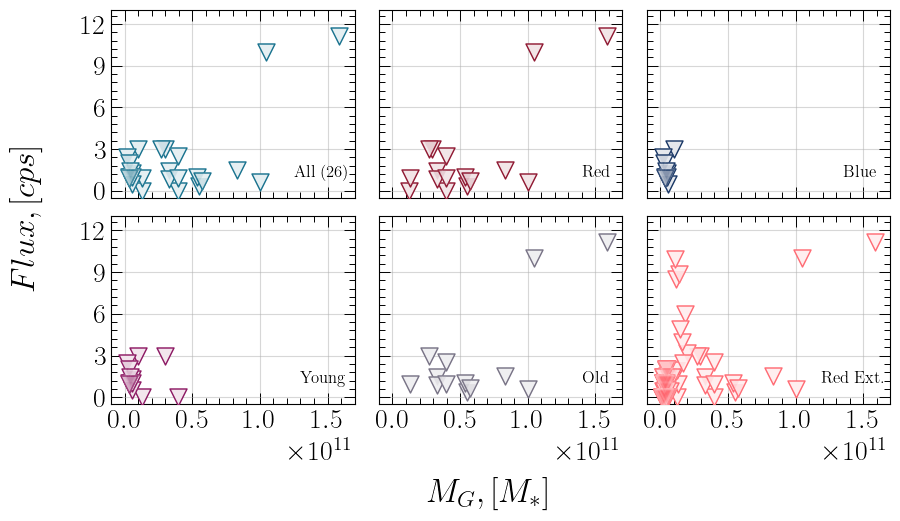

In [45]:
width=10;height=6;ff, ax = plt.subplots(2,3);ff.set_figwidth(width);ff.set_figheight(height);ff.tight_layout(pad=3)

#ff.supxlabel("Xray Flux for Each Member Galaxies as Function of Stellar Mass"); ff.supxlabel(r"$M_{\ast}$"); ff.supylabel(r"$Flux$");

ax[0,0].scatter(10**np.array(mem_data_m26[13]),mem_data_m26[21], marker='v',s=150,edgecolor=colours2[0],c='w',zorder=3, label="All (26)")
ax[0,1].scatter(10**np.array(red_m26[13]),red_m26[21],           marker='v',s=150,edgecolor=colours2[1],c='w',zorder=3, label="Red")
ax[0,2].scatter(10**np.array(blue_m26[13]),blue_m26[21],         marker='v',s=150,edgecolor=colours2[2],c='w',zorder=3, label="Blue")
ax[1,1].scatter(10**np.array(old_m26[13]),old_m26[21],       marker='v',s=150,edgecolor=colours2[3],c='w',zorder=3, label="Young")
ax[1,0].scatter(10**np.array(young_m26[13]),young_m26[21],           marker='v',s=150,edgecolor=colours2[4],c='w',zorder=3, label="Old")
ax[1,2].scatter(10**np.array(all_red_mass),all_red_flux,         marker='v',s=150,edgecolor=colours2[5],c='w',zorder=3, label="Red Ext.")

ax[0,0].scatter(10**np.array(mem_data_m26[13]),mem_data_m26[21], marker='v',s=150,edgecolor='w',c=colours2[0],alpha=0.1,zorder=20)
ax[0,1].scatter(10**np.array(red_m26[13]),red_m26[21],           marker='v',s=150,edgecolor='w',c=colours2[1],alpha=0.1,zorder=20)
ax[0,2].scatter(10**np.array(blue_m26[13]),blue_m26[21],         marker='v',s=150,edgecolor='w',c=colours2[2],alpha=0.1,zorder=20)
ax[1,1].scatter(10**np.array(old_m26[13]),old_m26[21],       marker='v',s=150,edgecolor='w',c=colours2[3],alpha=0.1,zorder=20)
ax[1,0].scatter(10**np.array(young_m26[13]),young_m26[21],           marker='v',s=150,edgecolor='w',c=colours2[4],alpha=0.1,zorder=20)
ax[1,2].scatter(10**np.array(all_red_mass),all_red_flux,         marker='v',s=150,edgecolor='w',c=colours2[5],alpha=0.1,zorder=20)



ax[0,0].set_ylim(-0.5,13)
ax[0,1].set_ylim(-0.5,13)
ax[0,2].set_ylim(-0.5,13);
ax[0,0].set_xlim(-0.1e11,1.7e11)
ax[0,1].set_xlim(-0.1e11,1.7e11)
ax[0,2].set_xlim(-0.1e11,1.7e11)
ax[1,0].set_xlim(-0.1e11,1.7e11)
ax[1,1].set_xlim(-0.1e11,1.7e11)
ax[1,2].set_xlim(-0.1e11,1.7e11)

ax[1,0].set_ylim(-0.5,13)
ax[1,1].set_ylim(-0.5,13)
ax[1,2].set_ylim(-0.5,13);
#ax[1,2].set_xlim(0,1.5e11)


# ax[0,0].legend(fontsize='small',loc='upper left');
# ax[0,1].legend(fontsize='small',loc='upper left');
# ax[0,2].legend(fontsize='small',loc='upper left');
# ax[1,0].legend(fontsize='small',loc='upper left');
# ax[1,1].legend(fontsize='small',loc='upper left');
# ax[1,2].legend(fontsize='small', loc='upper left');


ax[0,0].yaxis.set_minor_locator(MultipleLocator(0.6));ax[0,0].yaxis.set_major_locator(MultipleLocator(3))
ax[0,0].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[0,0].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[0,0].tick_params(axis='both', direction="in");
ax[0,0].tick_params(which="minor", axis="x", direction="in");ax[0,0].tick_params(which="minor", axis="y", direction="in")
ax[0,0].xaxis.set_ticks_position('both') ;ax[0,0].yaxis.set_ticks_position('both')
ax[0,0].grid(True, alpha=0.5, zorder=0)

ax[0,1].yaxis.set_minor_locator(MultipleLocator(0.6));ax[0,1].yaxis.set_major_locator(MultipleLocator(3))
ax[0,1].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[0,1].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[0,1].tick_params(axis='both', direction="in")
ax[0,1].tick_params(which="minor", axis="x", direction="in");ax[0,1].tick_params(which="minor", axis="y", direction="in")
ax[0,1].xaxis.set_ticks_position('both') ;ax[0,1].yaxis.set_ticks_position('both')
ax[0,1].grid(True, alpha=0.5, zorder=0)

ax[0,2].yaxis.set_minor_locator(MultipleLocator(0.6));ax[0,2].yaxis.set_major_locator(MultipleLocator(3))
ax[0,2].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[0,2].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[0,2].tick_params(axis='both', direction="in")
ax[0,2].tick_params(which="minor", axis="x", direction="in");ax[0,2].tick_params(which="minor", axis="y", direction="in")
ax[0,2].xaxis.set_ticks_position('both') ;ax[0,2].yaxis.set_ticks_position('both')
ax[0,2].grid(True, alpha=0.5, zorder=0)



ax[1,0].yaxis.set_minor_locator(MultipleLocator(0.6));ax[1,0].yaxis.set_major_locator(MultipleLocator(3))
ax[1,0].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[1,0].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[1,0].tick_params(axis='both', direction="in")
ax[1,0].tick_params(which="minor", axis="x", direction="in");ax[1,0].tick_params(which="minor", axis="y", direction="in")
ax[1,0].xaxis.set_ticks_position('both') ;ax[1,0].yaxis.set_ticks_position('both')
ax[1,0].grid(True, alpha=0.5, zorder=0)

ax[1,1].yaxis.set_minor_locator(MultipleLocator(0.6));ax[1,1].yaxis.set_major_locator(MultipleLocator(3))
ax[1,1].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[1,1].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[1,1].tick_params(axis='both', direction="in")
ax[1,1].tick_params(which="minor", axis="x", direction="in");ax[1,1].tick_params(which="minor", axis="y", direction="in")
ax[1,1].xaxis.set_ticks_position('both') ;ax[1,1].yaxis.set_ticks_position('both')
ax[1,1].grid(True, alpha=0.5, zorder=0)

ax[1,2].yaxis.set_minor_locator(MultipleLocator(0.6));ax[1,2].yaxis.set_major_locator(MultipleLocator(3))
ax[1,2].xaxis.set_minor_locator(MultipleLocator(0.1e11));ax[1,2].xaxis.set_major_locator(MultipleLocator(0.5e11))
ax[1,2].tick_params(axis='both', direction="in")
ax[1,2].tick_params(which="minor", axis="x", direction="in");ax[1,2].tick_params(which="minor", axis="y", direction="in")
ax[1,2].xaxis.set_ticks_position('both') ;ax[1,2].yaxis.set_ticks_position('both')
ax[1,2].grid(True, alpha=0.5, zorder=0)


ff.supxlabel(r"$M_G, [M_{\ast}]$")
ff.supylabel(r"$Flux, [cps]$")

plt.subplots_adjust(wspace=0.1) 
plt.subplots_adjust(hspace=0.1) 


ax[1,1].set_yticklabels([])
ax[1,2].set_yticklabels([])
ax[0,1].set_yticklabels([])
ax[0,2].set_yticklabels([])

ax[0,1].set_xticklabels([])
ax[0,0].set_xticklabels([])
ax[0,2].set_xticklabels([])


ax[0,0].text(1.25e11,1, 'All (26)', c='k', weight='bold',fontsize=12)
ax[0,1].text(1.4e11,1, 'Red', c='k',      weight='bold',fontsize=12)
ax[0,2].text(1.35e11,1, 'Blue', c='k',     weight='bold',fontsize=12)
ax[1,0].text(1.3e11,1, 'Young', c='k',    weight='bold',fontsize=12)
ax[1,1].text(1.4e11,1, 'Old', c='k',      weight='bold',fontsize=12)
ax[1,2].text(1.19e11,1, 'Red Ext.', c='k', weight='bold',fontsize=12)

plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/3_flux_vs_mass_6samps", dpi=250)


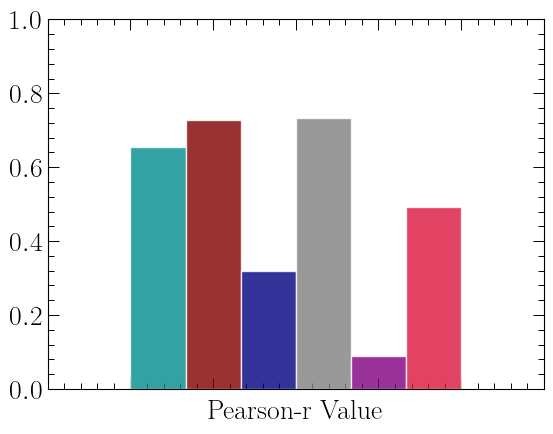

<Figure size 1000x800 with 0 Axes>

In [395]:
r_manual = pd.DataFrame({
    "All (26)":[
0.653671428],
    "Red":[
0.728887292],
    "Blue":[
0.319802586],
    "Old":[
0.734203833],
    "Young":[
0.089077754],
    "Red Ex.":[0.491071319012478],
    }, 
    index=[""]
)

r_manual_reversed = r_manual#.iloc[:, ::-1]

colours=['#e69216', '#e4263f', '#2f4b7c','gray', '#d45087']
#colours2=['darkcyan', 'maroon', 'navy','gray', 'purple', 'crimson']

ax1 = r_manual_reversed.plot(kind="bar", color=colours2, edgecolor='white', zorder=2, width=1, legend=False,alpha=0.8)
#ax1 =r_manual_reversed.plot(kind="bar", color='white', edgecolor=colours2, width=1, legend=False,alpha=1,zorder=5)


#plt.title("Pearson-r Value For Five different Flux Methods and 4 Sub-Samples")



plt.xlabel("Pearson-r Value")
#plt.ylabel("Method")
plt.ylim(0.00,1.0)
#plt.grid(alpha=0.3,zorder=0)

plt.figure(figsize=(10, 8))

ax1.xaxis.set_major_locator(MultipleLocator(0.25))
ax1.xaxis.set_minor_locator(MultipleLocator(0.05))
ax1.yaxis.set_minor_locator(MultipleLocator(0.04))
ax1.yaxis.set_major_locator(MultipleLocator(0.2))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
#ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
#ax1.grid(True, alpha=0.5, zorder=10)

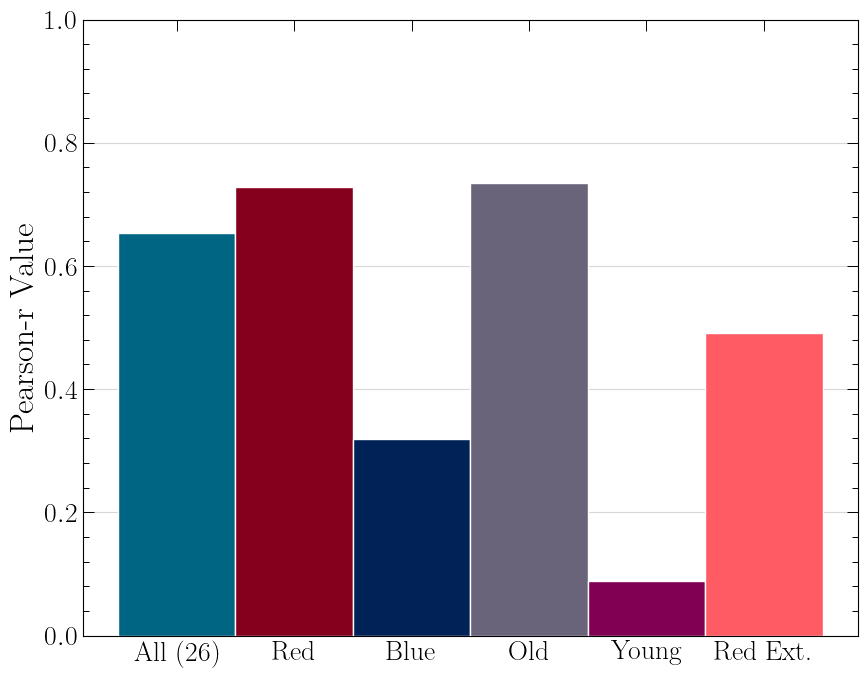

In [423]:
Pears_r_bar = [0.653671428,0.728887292,0.319802586,0.734203833,0.089077754,0.491071319012478]
width=10;height=8;ff, ax1 = plt.subplots(1,1, sharex=True, sharey=True);ff.set_figwidth(width);ff.set_figheight(height)

ax1.bar(names, Pears_r_bar, color=colours2, edgecolor='white', zorder=2, width=1, linewidth=1)

#plt.title("Pearson-r Value For Five different Flux Methods and 4 Sub-Samples")



ax1.set_ylabel("Pearson-r Value", fontsize=24)
#plt.ylabel("Method")
#ax1.set_xlim(-0.6,0.6)

#ax1.xaxis.set_major_locator(MultipleLocator(1/6))
#ax1.xaxis.set_minor_locator(MultipleLocator(0.05))
ax1.yaxis.set_minor_locator(MultipleLocator(0.04))
ax1.yaxis.set_major_locator(MultipleLocator(0.2))
#ax1.tick_params(axis='both', direction="in")
#ax1.tick_params(which="minor", axis="x", direction="in")
#ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid('y', alpha=0.5, zorder=10)
#ax1.set_yscale('log')
ax1.xaxis.grid(False)
ax1.set_ylim(0,1)

#shifted_positions = np.arange(len(df['Category'])) + 1
#ax1.set_xticks(shifted_positions)
#ax1.set_xticklabels(df['Category'])


plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/3_pearson_r_6samps", dpi=250)


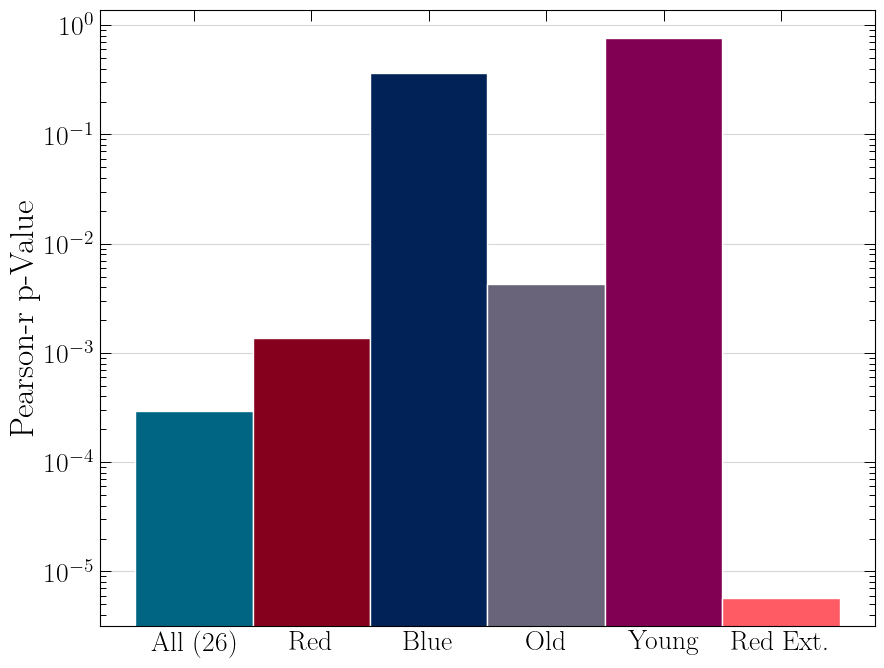

In [43]:
r_manual = pd.DataFrame({
    "All (26)":[(0.000293093189697031)],
    "Red":     [(0.00135930994077094)],
    "Blue":    [(0.367695723348949)],
    "Old":     [(0.0042686367162042)],
    "Young":   [(0.772284771621217)],
    "Red Ex.": [(5.77278738279158E-06)],
    }, 
    index=[""]
)

names = ['All (26)', 'Red', 'Blue', 'Old', 'Young' , 'Red Ext.']

r_corr_bar =[0.000293093189697031,0.00135930994077094,0.367695723348949,0.0042686367162042,0.772284771621217,5.77278738279158E-06]


r_manual_reversed = r_manual#.iloc[:, ::-1]

colours=['#e69216', '#e4263f', '#2f4b7c','gray', '#d45087']
colours2=['#006483', '#84001c', '#012256','#696479', '#810053', '#ff5b65']

#ax1 = r_manual_reversed.plot(kind="bar", color=colours2, edgecolor='white', zorder=2, width=1, legend=False, linewidth=2)

width=10;height=8;ff, ax1 = plt.subplots(1,1, sharex=True, sharey=True);ff.set_figwidth(width);ff.set_figheight(height)

ax1.bar(names, r_corr_bar, color=colours2, edgecolor='white', zorder=2, width=1, linewidth=1)

#plt.title("Pearson-r Value For Five different Flux Methods and 4 Sub-Samples")



ax1.set_ylabel("Pearson-r p-Value", fontsize=24)
#plt.ylabel("Method")
#ax1.set_xlim(-0.6,0.6)

#ax1.xaxis.set_major_locator(MultipleLocator(1/6))
#ax1.xaxis.set_minor_locator(MultipleLocator(0.05))
#ax1.yaxis.set_minor_locator(MultipleLocator(0.2))
#ax1.yaxis.set_major_locator(MultipleLocator(1))
#ax1.tick_params(axis='both', direction="in")
#ax1.tick_params(which="minor", axis="x", direction="in")
#ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid('y', alpha=0.5, zorder=10)
ax1.set_yscale('log')
ax1.xaxis.grid(False)

#shifted_positions = np.arange(len(df['Category'])) + 1
#ax1.set_xticks(shifted_positions)
#ax1.set_xticklabels(df['Category'])
plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/3_pearson_p_log_6samps", dpi=250)


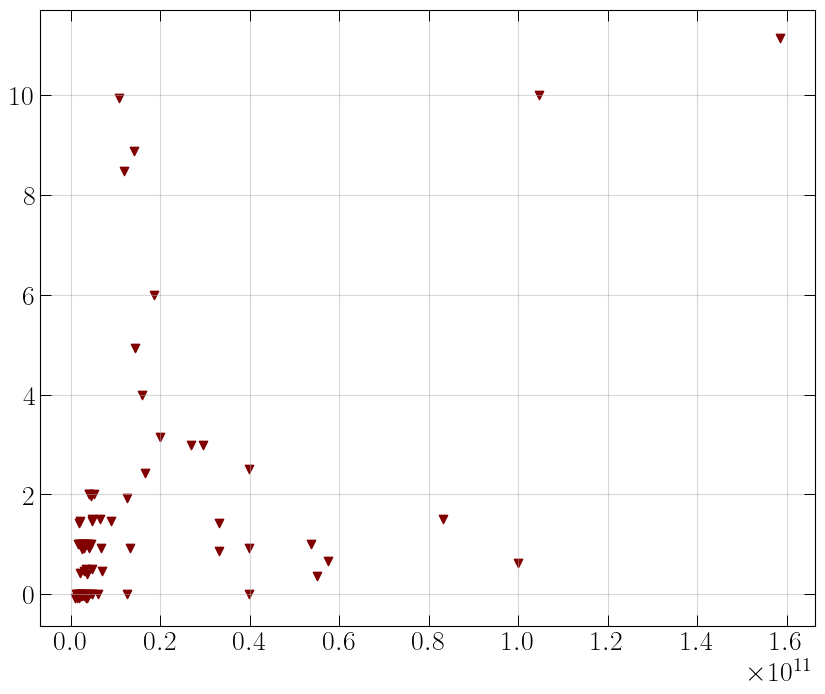

In [306]:


# we can add these to the whole red sample and then recorrelate:

# faint_red_m = [pot_members[22][i] for i in range(len(pot_members[22])) if pot_members[16][i] in ID_]
# faint_red_f = [pot_members[23][i] for i in range(len(pot_members[23])) if pot_members[16][i] in ID_]

# red_masses = list(red_m26[13] ) + faint_red_m; red_fluxes = list(red_m26[21] ) + faint_red_f

# red_r, red_p =  sp.stats.pearsonr(10**np.array(red_masses), red_fluxes)

# print(red_r,red_p)

width=10;height=8;ff, ax1 = plt.subplots(1,1, sharex=True, sharey=True);ff.set_figwidth(width);ff.set_figheight(height)
#ax1.set_xlim(20,25)
#ax1.set_ylim(9.5,11.5)
#ax1.set_title("Galaxy Stellar Mass as a Function of Magnitude")
#ax1.set_ylabel(r"$M_{\ast}$, $[log_{10}\frac{M}{M_{\ast}}]$")
#ax1.set_xlabel(r"$F140W_{Kron}(AB)$")

ax1.scatter(10**np.array(all_red_mass), all_red_flux, marker='v', c='maroon')

# ax1.xaxis.set_major_locator(MultipleLocator(1))
# ax1.xaxis.set_minor_locator(MultipleLocator(0.2))
# ax1.yaxis.set_minor_locator(MultipleLocator(0.1))
# ax1.yaxis.set_major_locator(MultipleLocator(0.5))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid(True, alpha=0.5, zorder=10)

plt.show()

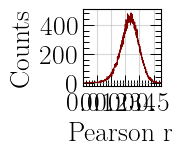

In [314]:
# now lets try and plot these quantities ad see if anything pops out:

nbins = 1000
r_100k_hist=np.histogram(r_100k, bins=nbins)

width=1;height=1;ff, ax1 = plt.subplots(1,1, sharex=True, sharey=True);ff.set_figwidth(width);ff.set_figheight(height)
ax1.set_xlim(0,0.55)
#ax1.set_ylim(9.5,11.5)
#ax1.set_title("Pearson r for 100k samples of Potential Members")
ax1.set_ylabel(r"Counts")
ax1.set_xlabel(r"Pearson r")

ax1.plot(r_100k_hist[1][0:nbins], r_100k_hist[0], c='maroon', linewidth=0.5)
#ax1.axvline(0.329)

ax1.xaxis.set_major_locator(MultipleLocator(0.1))
ax1.xaxis.set_minor_locator(MultipleLocator(0.02))
ax1.yaxis.set_minor_locator(MultipleLocator(40))
ax1.yaxis.set_major_locator(MultipleLocator(200))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('bottom') 
ax1.yaxis.set_ticks_position('both')
ax1.grid(True, alpha=0.5, zorder=10)
plt.show()

In [315]:
# next step is to generate a cumulative mass function for galaxies in the sample:

# we now want to find the radial cumulative number and mass functions for the galaxy cluster.
# procedure here is to take the RA and Dec of each object and convert it into a centred 
# radial position on the sky (may need some help from WCS).

# going to see if this works: 
# 1: subtract x-ray centre from member RA and DEC
# 2: use the cosmology calculator to find the kpc/" which we have previously
# 3: convert the differences from 1) into kpc distances using 2
# 4: plot the kpc positions on the xray frame in kpc pixel units from before
# 5: find R = sqrt(RA^2 + DEC^2)
# 6: find both the cumulative number and mass distributions as a function of R

# galaxy positions are: 
mem_RA = mem_data[1]; mem_DEC=mem_data[2]

mem_RA_m37=mem_data_m37[1]; mem_RA_m26=mem_data_m26[1]
mem_DEC_m37=mem_data_m37[2]; mem_DEC_m26=mem_data_m26[2]


# conversion factor is:

arcmin_to_kpc = 8.530 # kpc/"
degree_to_kpc = arcmin_to_kpc * 3600 # kpc/degree

# centre of xray image is:
xray_cdelt = xray_wcs.wcs.cdelt

xray_RA = 34.409; xray_DEC = -3.7431
# but we need the distance to the centre of the BCG i think?:

bcg_RA = mem_RA[0]; bcg_DEC = mem_DEC[0]

bcg_RA_kpc = bcg_RA * degree_to_kpc; bcg_DEC_kpc = bcg_DEC * degree_to_kpc;

# differences are then:

mem_RA_diff_m37 = [mem_RA[i] for i in range(len(mem_RA_m37))];mem_RA_diff_m26 = [mem_RA[i] for i in range(len(mem_RA_m26))];
mem_DEC_diff_m37 = [mem_DEC[i] for i in range(len(mem_DEC_m37))];mem_DEC_diff_m26 = [mem_DEC[i] for i in range(len(mem_DEC_m26))]

# in kpc:

mem_RA_kpc_m26 = [mem_RA_diff_m26[i]*degree_to_kpc for i in range(len(mem_RA_m26))]
mem_DEC_kpc_m37 = [mem_DEC_diff_m37[i]*degree_to_kpc for i in range(len(mem_RA_m37))]

mem_RA_kpc_m37 = [mem_RA_diff_m37[i]*degree_to_kpc for i in range(len(mem_RA_m37))]
mem_DEC_kpc_m26 = [mem_DEC_diff_m26[i]*degree_to_kpc for i in range(len(mem_RA_m26))]

kpc_pos_m26 = np.array([mem_RA_kpc_m26 - bcg_RA_kpc, mem_DEC_kpc_m26 - bcg_DEC_kpc])
kpc_pos_m37 = np.array([mem_RA_kpc_m37 - bcg_RA_kpc, mem_DEC_kpc_m37 - bcg_DEC_kpc])


def make_coords(mid, npoints, inc):
    half = inc * (npoints-1)/2
    start = mid - half
    end = mid + half
    
    vals = np.linspace(start,end,npoints)
    
    return vals

xray_x_mc = make_coords(xray_RA, 900, inc = xray_cdelt[0]) - bcg_RA
xray_y_mc = make_coords(xray_DEC, 900, inc = xray_cdelt[0]) - bcg_DEC

xray_x_mkpc = xray_x_mc * degree_to_kpc; xray_y_mkpc = xray_y_mc * degree_to_kpc
#xray_x_mkpc = xray_x_mkpc - bcg_RA_kpc; xray_y_mkpc= xray_y_kpc#+ bcg_DEC_kpc

xray_xp_mkpc, xray_yp_mkpc = np.meshgrid(xray_x_mkpc, xray_y_mkpc)

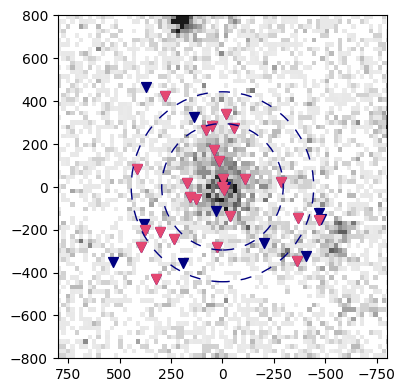

In [316]:
width=4;height=4;ff, ax = plt.subplots(1,1);ff.set_figwidth(width);ff.set_figheight(height); ff.tight_layout(pad=1.0)
ax.pcolormesh(xray_xp_mkpc,xray_yp_mkpc[::-1],xray_image,vmin=0.004, vmax= 10,cmap='gray_r', alpha=0.9, zorder=0)#, interpolation='none')

ax.scatter(kpc_pos_m37[0], kpc_pos_m37[1],s=50, marker='v', c='navy')
ax.scatter(kpc_pos_m26[0], kpc_pos_m26[1],s=50, marker='v', c='#e44872')

ax.set_xlim(-800,800)
ax.set_ylim(-800,800)

circ_500 = plt.Circle((0,0),295,fill = False,color='navy', linestyle=(0,(8,8)), zorder=10)#, label=r'$r_{500}$')
ax.add_patch(circ_500) 

circ_200 = plt.Circle((0,0),443,fill = False,color='navy', linestyle=(0,(8,8)), zorder=10)#, label=r'$r_{500}$')
ax.add_patch(circ_200) 

ax.invert_xaxis()
plt.show()

In [317]:
# now we need to find the radial distance from the BCG as in step 5 above:

radial_pos_m26 = [np.sqrt((kpc_pos_m26[0][i]**2 + kpc_pos_m26[1][i])) for i in range(len(kpc_pos_m26[0]))]
radial_pos_m37 = [np.sqrt((kpc_pos_m37[0][i]**2 + kpc_pos_m37[1][i])) for i in range(len(kpc_pos_m37[0]))]

# We can sort this in increasing order: but also need mass to be sorted
mem_ID_m26 = mem_data_m26[0]; mem_ID_m37 = mem_data_m37[0]; 

radial_data_m26 = np.array([mem_ID_m26, radial_pos_m26, mem_data_m26[13]])
radial_data_m37 = np.array([mem_ID_m37, radial_pos_m37, mem_data_m37[13]])


rad_sort_m37= np.array(sorted(radial_data_m37.T, key=itemgetter(1), reverse=False)).T
rad_sort_m26= list(np.array(sorted(radial_data_m26.T, key=itemgetter(1), reverse=False)).T)


# we now need to generate cumulative mass and number distributions:

cum_mass_m26 = [sum(10**rad_sort_m26[2][0:i]) for i in range(len(mem_ID_m26))] 
cum_mass_m37 = [sum(10**rad_sort_m37[2][0:i]) for i in range(len(mem_ID_m37))]

cum_num = np.linspace(0, 50,50)


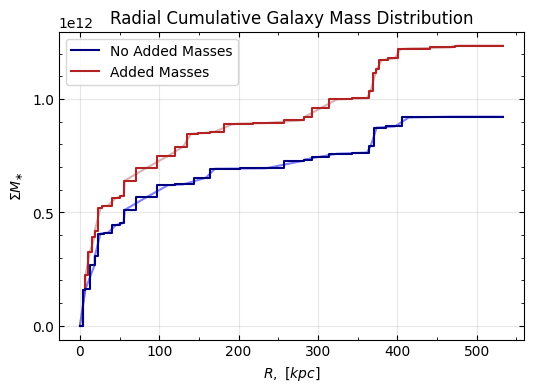

In [318]:
width=6;height=4;ff, ax1 = plt.subplots(1,1);ff.set_figwidth(width);ff.set_figheight(height)

#ax1.set_xlim(20,25);ax1.set_ylim(-0.2e11, 1.75e11)
ax1.set_title("Radial Cumulative Galaxy Mass Distribution")
ax1.set_xlabel(r"$R, \ [kpc]$")
ax1.set_ylabel(r"$\Sigma M_{\ast}$")

ax1.step(list(rad_sort_m26[1])+[max(rad_sort_m37[1])],cum_mass_m26+[max(cum_mass_m26)],where='mid', label='No Added Masses', c='navy', zorder=5)
ax1.step(rad_sort_m37[1],np.array(cum_mass_m37), where='mid', label='Added Masses', c='firebrick')
ax1.plot(rad_sort_m37[1],np.array(cum_mass_m37),c='maroon', alpha=0.3, zorder=0)
ax1.plot(list(rad_sort_m26[1])+[max(rad_sort_m37[1])],cum_mass_m26+[max(cum_mass_m26)],c='blue', zorder=1, alpha=0.5)

ax1.yaxis.set_minor_locator(MultipleLocator(1e11));ax1.yaxis.set_major_locator(MultipleLocator(5e11))
ax1.xaxis.set_minor_locator(MultipleLocator(50));ax1.xaxis.set_major_locator(MultipleLocator(100))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid(True, alpha=0.3, zorder=10)
ax1.legend()

plt.show()

In [319]:
# we want to make a radial density profile from the xray image:

# first need a function to calculate this value:

def radial_profile(data, centre, factor=21.325):
    X,Y = np.indices((data.shape))
    R = np.sqrt((X-centre[0])**2+ (Y-centre[1])**2)
    R = R.astype(int)

    tbin = np.bincount(R.ravel(), data.ravel())
    nr = np.bincount(R.ravel())
    profile = tbin / nr
    radii = factor*np.linspace(0, len(tbin), len(tbin))
    return [radii,profile]

# we can now calculate the radial profile for both the xray and smoothed xray:

# first data:
xray = fits.open(xray_path)[0].data; smooth = fits.open(smooth_path)[0].data

# centre of the BCG IN PIXELS:

centre_bcg = (428,414); centre_bcgs = (120,121)

# profiles:

xray_profile = radial_profile(xray, centre_bcg); smooth_profile = radial_profile(np.nan_to_num(smooth), centre_bcgs)

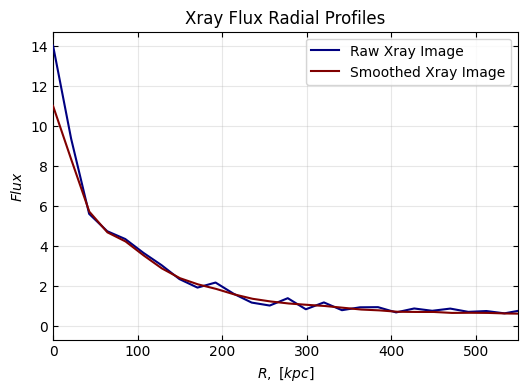

In [1229]:
width=6;height=4;ff, ax1 = plt.subplots(1,1);ff.set_figwidth(width);ff.set_figheight(height)

ax1.set_xlim(0,550);#ax1.set_ylim(-0.2e11, 1.75e11)
ax1.set_title("Xray Flux Radial Profiles")
ax1.set_xlabel(r"$R, \ [kpc]$")
ax1.set_ylabel(r"$Flux$")

ax1.plot(xray_profile[0], xray_profile[1], label='Raw Xray Image', c='navy', zorder=3)
ax1.plot(smooth_profile[0], smooth_profile[1], label='Smoothed Xray Image', c='Maroon', zorder=4)

#ax1.yaxis.set_minor_locator(MultipleLocator(1e11));ax1.yaxis.set_major_locator(MultipleLocator(5e11))
#ax1.xaxis.set_minor_locator(MultipleLocator(50));ax1.xaxis.set_major_locator(MultipleLocator(100))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid(True, alpha=0.3, zorder=10)
ax1.legend()

plt.show()

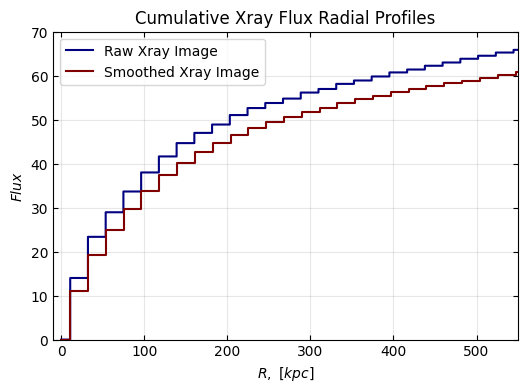

In [781]:
# we can also generate cumulative distributions and normalize them:

cum_xray = [sum(xray_profile[1][0:i]) for i in range(len(xray_profile[1]))]
cum_smooth = [sum(smooth_profile[1][0:i]) for i in range(len(smooth_profile[1]))]

width=6;height=4;ff, ax1 = plt.subplots(1,1);ff.set_figwidth(width);ff.set_figheight(height)

ax1.set_xlim(-10,550);ax1.set_ylim(0,70)
ax1.set_title("Cumulative Xray Flux Radial Profiles")
ax1.set_xlabel(r"$R, \ [kpc]$")
ax1.set_ylabel(r"$Flux$")

ax1.step(xray_profile[0], cum_xray, label='Raw Xray Image', c='navy', zorder=3, where='mid')
ax1.step(smooth_profile[0], cum_smooth, label='Smoothed Xray Image', c='Maroon', zorder=4,where='mid')

#ax1.yaxis.set_minor_locator(MultipleLocator(1e11));ax1.yaxis.set_major_locator(MultipleLocator(5e11))
#ax1.xaxis.set_minor_locator(MultipleLocator(50));ax1.xaxis.set_major_locator(MultipleLocator(100))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid(True, alpha=0.3, zorder=10)
ax1.legend()

plt.show()

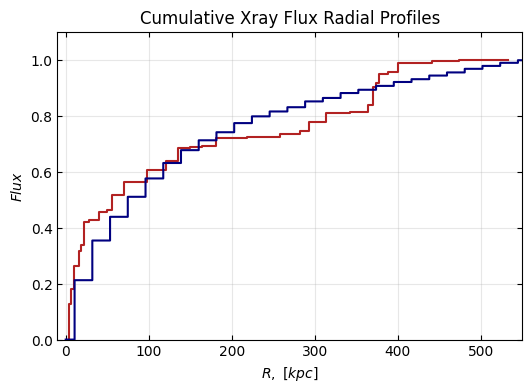

In [1118]:
cum_xray = [sum(xray_profile[1][0:i]) for i in range(len(xray_profile[1]))]
cum_smooth = [sum(smooth_profile[1][0:i]) for i in range(len(smooth_profile[1]))]

width=6;height=4;ff, ax1 = plt.subplots(1,1);ff.set_figwidth(width);ff.set_figheight(height)

ax1.set_xlim(-10,550);ax1.set_ylim(0,1.1)
ax1.set_title("Cumulative Xray Flux Radial Profiles")
ax1.set_xlabel(r"$R, \ [kpc]$")
ax1.set_ylabel(r"$Flux$")

ax1.step(xray_profile[0], np.array(cum_xray)/66, c='navy', zorder=3, where='mid')
ax1.step(rad_sort_m37[1],np.array(cum_mass_m37)/max(cum_mass_m37), where='mid', c='firebrick')

#ax1.loglog(xray_profile[0], np.array(cum_xray)/66, c='navy', zorder=3)
#ax1.loglog(rad_sort_m37[1],np.array(cum_mass_m37)/max(cum_mass_m37), c='firebrick')


#ax1.yaxis.set_minor_locator(MultipleLocator(1e11));ax1.yaxis.set_major_locator(MultipleLocator(5e11))
#ax1.xaxis.set_minor_locator(MultipleLocator(50));ax1.xaxis.set_major_locator(MultipleLocator(100))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid(True, alpha=0.3, zorder=10)
#ax1.legend()

plt.show()